# 1D spectral analysis and light curve calculation from DL3 (energy-dependent angular cuts)

Originally created by Chaitanya Priyadarshi and adapted to work with Gammapy v1.1 and the latest DL3 files produced by lstchain v0.10.

This is a combination of Gammapy tutorials for the **1D spectral analysis following the ON-OFF forward-folding method and light curve calculation** for point-like-source observations in wobble mode.

Original notebooks can be accessed at:

 - https://docs.gammapy.org/1.1/tutorials/analysis-1d/spectral_analysis_rad_max.html (from DL3 with energy-dependent angular cuts, the *approach followed in this notebook*)
 - https://docs.gammapy.org/1.1/tutorials/analysis-1d/spectral_analysis.html (from DL3 with global gammaness and angular cuts)
 - https://docs.gammapy.org/1.1/tutorials/analysis-time/light_curve.html
 - https://docs.gammapy.org/1.1/tutorials/analysis-time/light_curve_flare.html


It reduces a set of DL3 files (with energy-dependent angular cuts) into an energy-binned dataset, fits a spectral model to this dataset, calculates spectral flux points and computes the light curve.

Here it is also described how to write all these objects to files, read them back, inspect and plot the results.

-----------
## Content

### 0. Inspect the DL3 file content
### 1. Read the DL3 index files and load the data
### 2. Apply selection filters to the list of DL3 files
### 3. Define the base geometry for the 1D spectrum dataset
### 4. Generate some dataset makers for data reduction
### 5. Perform data reduction over all selected observations and compile them into a Dataset
### 6. Save the Dataset to OGIP files
### 7. Get the reference energy for a log-parabola model fit, by checking the pivot energy for a power-law fit
### 8. Perform fitting, modeling and check some statistics
### 9. Plot the LC and SED
### 10. Save SED and LC flux points, and models to separate files 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
from regions import CircleSkyRegion, PointSkyRegion
from pathlib import Path
import os
import pickle

In [2]:
from gammapy.data import DataStore, EventList
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator, FluxPoints
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time
import astropy.units as u

In [3]:
# Define the path to the DL3 files
base_dir = Path("/fefs/aswg/workspace/analysis-school-2024/DL3")
dl3_path = base_dir / "Crab_Dec_2023"

# 0. Inspect the DL3 file content

In [4]:
# Open one of the DL3 files from the directory
filename = dl3_path / "dl3_LST-1.Run15996.fits"
events = EventList.read(filename)

In [5]:
# Have a look at the event list (here the first 10 events)
events.table[:10]

EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,MULTIP,GLON,GLAT,ALT,AZ
,s,deg,deg,TeV,,,deg,deg,deg,deg
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
9,163991012.71643734,83.05535691189358,21.61531074233613,0.02285192335101981,0.4473029916670314,1,184.60656868700892,-6.451171668612893,81.58789373747902,146.80890857926516
11,163991012.7165389,86.48926839414618,21.297928277054282,0.062472970167058925,0.6032040922944424,1,186.57074338267057,-3.9039582117942846,79.3702582791676,132.63463070754148
20,163991012.71722865,83.27101991592691,22.287370939533393,0.07635453755407047,0.5196960591728061,1,184.14510108645783,-5.9208912985373185,82.04243464830726,143.05657725072427
33,163991012.71868372,84.6982232886882,21.4204785247562,0.036365469577457996,0.4823900580639558,1,185.591458522201,-5.262072152892625,80.55794504981088,139.40753994269937
34,163991012.71870375,82.56921455298837,24.57339724493511,0.10012679875654935,0.6147531590423652,1,181.8638858944288,-5.223981913433577,84.2312668644237,135.238478469809
43,163991012.71962667,85.06893657418489,21.48843843379072,0.026456931136161786,0.44795355650437607,1,185.71599786252116,-4.9330221836290695,80.39472063879293,137.52487611920003
47,163991012.72020125,85.02450343945958,23.055678555588102,0.026192614959915386,0.44648803806660625,1,184.3579237674875,-4.14236342932072,81.572079424905,130.9016703733129
57,163991012.72142076,85.87144032943704,21.919673633753987,0.02209409837167297,0.45406458669760824,1,185.73910989810264,-4.07199713478017,80.21647959498705,132.51891262895356


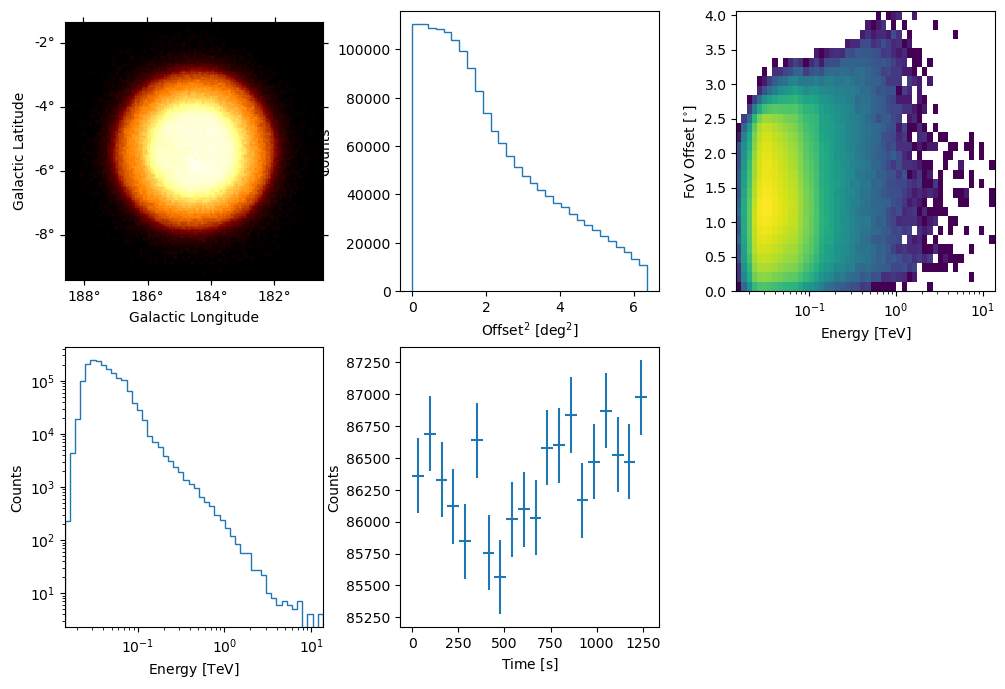

In [6]:
# You can have a look of the events with
events.peek()

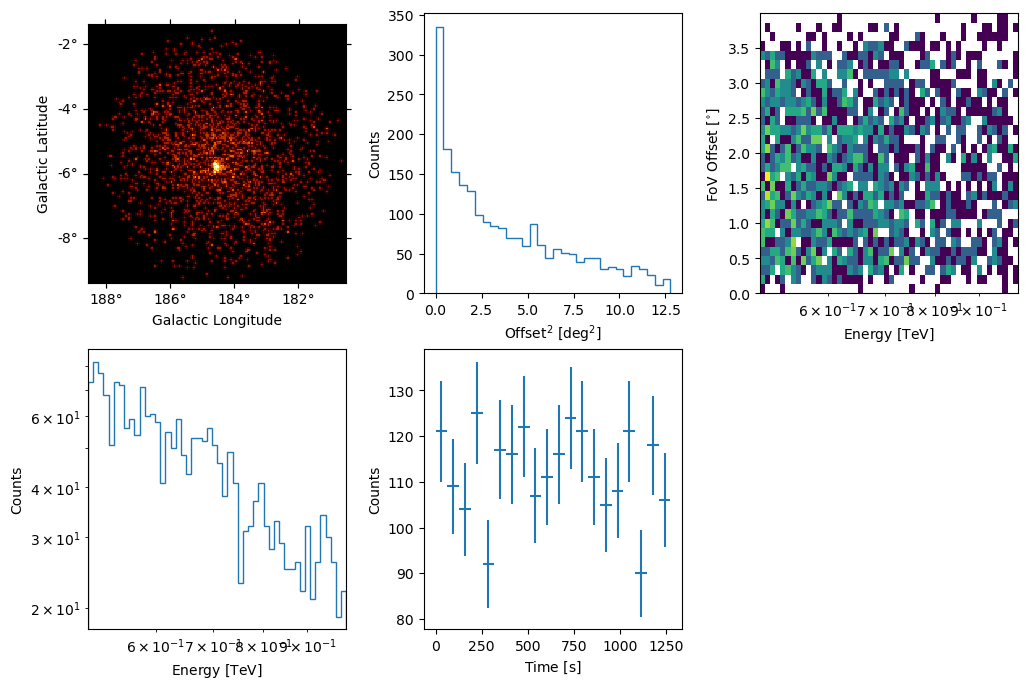

In [7]:
# You can select events based any parameter on the table above, e.g. energy:
selected_energy = events.select_energy([500 * u.GeV, 1 * u.TeV])
selected_energy.peek()

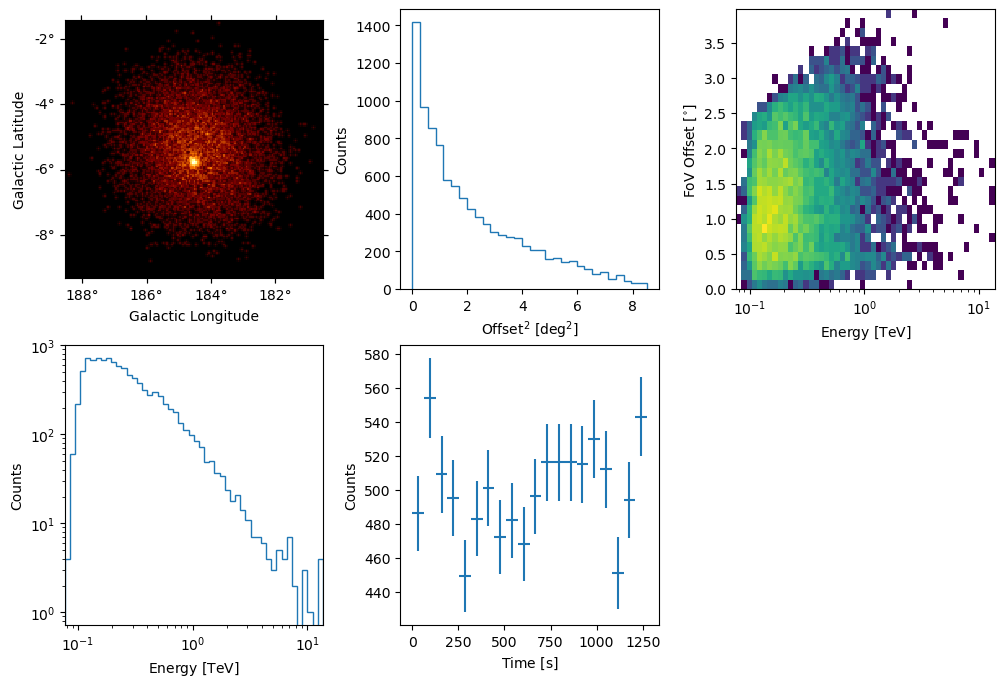

In [8]:
# or gammaness:
gh_range = [0.9, 1]
selected_events_gh = events.select_parameter(parameter="GAMMANESS", band=gh_range)
selected_events_gh.peek()

# 1. Read the DL3 index files and load the data

Let's load now all the DL3 files together.
If the DL3 index files are not present, run the `lstchain_create_dl3_index_files` for the given DL3 files.

`lstchain_create_dl3_index_files -d $dl3_path`  (by default create the index files in the same directory)

In [9]:
total_datastore = DataStore.from_dir(dl3_path)

# ogip_path = dl3_path / "OGIP"
ogip_path = Path("./output/post_DL3_analysis/OGIP")

# Create the Paths if they do not exist already
ogip_path.mkdir(exist_ok=True, parents=True)

In [10]:
# Let's have a first look at the first 5 entries of the table from all observations present in the index files. 
# It contains run-wise information.
total_datastore.obs_table[:5]

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10,bytes8,int64,bytes5,bytes5
15996,2023-12-12,01:03:32.716,2023-12-12,01:24:46.000,83.98636887364519,22.244853662510675,7.229101366271891,82.77089863372811,156.0220904139546,83.633212,22.01446,163991012.71643734,163992286.00045753,1273.28476023674,1273.2840201854706,1198.621328293564,0.941361560057238,CrabNebula,POINTING,1,LST-1,LST-1
15997,2023-12-12,01:25:09.142,2023-12-12,01:46:42.719,83.32132228119357,21.806782750559595,7.5625771574111695,82.43742284258883,200.8965127240037,83.633212,22.01446,163992309.14209914,163993602.7194965,1293.579003572464,1293.5773973464966,1223.54481424378,0.9458601375445401,CrabNebula,POINTING,1,LST-1,LST-1
15998,2023-12-12,01:47:04.572,2023-12-12,02:09:10.444,83.97620041854351,22.18816246156717,9.629253947262612,80.37074605273739,228.39475695982156,83.633212,22.01446,163993624.57151628,163994950.4439993,1325.861388206482,1325.8724830150604,1251.8481891560714,0.9441772724443468,CrabNebula,POINTING,1,LST-1,LST-1
15999,2023-12-12,02:09:32.429,2023-12-12,02:31:04.931,83.31633216983332,21.799122620483505,14.484203071949764,75.51579692805024,244.2163213927007,83.633212,22.01446,163994972.42873025,163996264.93061996,1292.5027601718903,1292.501889705658,1222.6267511963174,0.9459374392621954,CrabNebula,POINTING,1,LST-1,LST-1
16001,2023-12-12,02:54:01.899,2023-12-12,03:16:34.492,83.33396759920551,21.797345309423804,23.880664827507516,66.11933517249248,258.8017774907763,83.633212,22.01446,163997641.8993883,163998994.49152517,1352.5935142040253,1352.5921368598938,1285.200343281178,0.9501748528178424,CrabNebula,POINTING,1,LST-1,LST-1


In [11]:
# Also you can have a look at the HDU table, which contains information on the data 
# and instrument response function files for each observation
total_datastore.hdu_table[:6]

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes8,bytes10,bytes1,bytes23,bytes17,int64
15996,events,events,.,dl3_LST-1.Run15996.fits,EVENTS,152035200
15996,gti,gti,.,dl3_LST-1.Run15996.fits,GTI,152035200
15996,pointing,pointing,.,dl3_LST-1.Run15996.fits,POINTING,152035200
15996,aeff,aeff_2d,.,dl3_LST-1.Run15996.fits,EFFECTIVE AREA,152035200
15996,edisp,edisp_2d,.,dl3_LST-1.Run15996.fits,ENERGY DISPERSION,152035200
15996,rad_max,rad_max_2d,.,dl3_LST-1.Run15996.fits,RAD_MAX,152035200


# 2. Selection filters for the observations

Based on the run-wise information from the previous table, filters can be applied to select just a subset of the observation list based on source name, zenith angle or livetime.

This list of observations based on similar filters can be also obtained beforehand by using the [data quality notebook](https://github.com/cta-observatory/cta-lstchain/blob/main/notebooks/data_quality.ipynb) (recommended). Then you can directly pass this list of `obs_id` to `get_observations` method of `DataStore` object below.

In [12]:
# Get the object name from the OBS Table, assuming all the DL3 files are of the same single source.
# If not, then select a single object, to produce the relevant Spectrum Dataset

obj_name = np.unique(total_datastore.obs_table["OBJECT"])[0]
print("The source is", obj_name)

max_zen = 35  # in deg for a maximum limit on zenith pointing of observations
min_time = 300  # in seconds for minimum livetime of each observation

The source is CrabNebula


In [13]:
total_obs_list = total_datastore.obs_table["OBS_ID"].data
observations_total = total_datastore.get_observations(
    total_obs_list, 
    required_irf=["aeff", "edisp", "rad_max"],  # By default, "full-enclosure" : ["events", "gti", "aeff", "edisp", "psf", "bkg"]
                        # If not all IRFs are present, the entry will be skipped 
    skip_missing=False # Skip missing observations, within the list provided earlier
)

# 3. Make selection of observations

In [14]:
d_time = total_datastore.obs_table["LIVETIME"] > min_time
d_zen = total_datastore.obs_table["ZEN_PNT"] < max_zen
d_obj = total_datastore.obs_table["OBJECT"] == obj_name

obs_table_selected = total_datastore.obs_table[d_zen & d_obj & d_time]
obs_id_list = obs_table_selected["OBS_ID"]

observations_sel = total_datastore.get_observations(
    obs_id_list, 
    required_irf="point-like"
)

In [15]:
print('Observation runs selected are:', obs_id_list.data)
print(f'Total livetime of all observations: {total_datastore.obs_table["LIVETIME"].to(u.h).sum():.1f}')
print(f'Total livetime of selected observations {obs_table_selected["LIVETIME"].data.sum()/3600:.1f} hrs')

Observation runs selected are: [15996 15997 15998 15999 16001 16002 16003 16066 16069 16070 16071 16072
 16073 16074 16075 16173 16174 16177 16178 16179 16180 16181 16182 16183]
Total livetime of all observations: 7.6 h
Total livetime of selected observations 7.6 hrs


# 4. Define Target position and energy ranges for reconstructed events

In [16]:
target_position = SkyCoord.from_name("Crab", frame='icrs')
target_position

<SkyCoord (ICRS): (ra, dec) in deg
    (83.6287, 22.0147)>

If we were using global theta cut, this is the way of getting the theta cut (`RAD_MAX` key) used for the IRF production.

Here we will use energy-dependent cuts, therefore the following is not executed in this example.

```
# Find the fixed global theta cut used for creating the IRFs

theta_cut = observations_sel[0].aeff.meta["RAD_MAX"]
print("Theta cut applied for creating the IRF in the selected DL3 file,", theta_cut)

# Converting the value into astropy.units to be used for defining the ON region with CircleSkyRegion
on_region_radius = u.Quantity(theta_cut)
```

In [17]:
# The metadata of the DL3 contains the efficiency of the cuts used for the DL3 production.
observations_sel[0].aeff.meta

OrderedDict([('CREATOR', 'pyirf v0.10.1'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('HDUCLASS', 'GADF'),
             ('HDUCLAS1', 'RESPONSE'),
             ('HDUCLAS2', 'EFF_AREA'),
             ('HDUCLAS3', 'POINT-LIKE'),
             ('HDUCLAS4', 'AEFF_2D'),
             ('DATE', '2023-12-17 16:53:39.158'),
             ('TELESCOP', 'CTA-N'),
             ('INSTRUME', 'LST-1'),
             ('FOVALIGN', 'RADEC'),
             ('ZEN_PNT', 10.0),
             ('AZ_PNT', 102.199),
             ('B_TOTAL', 38.592769622802734),
             ('B_INC', 0.6519277095794678),
             ('B_DEC', -0.08447393774986267),
             ('B_DELTA', 50.36070131494917),
             ('GH_EFF', 0.7),
             ('TH_CONT', 0.7),
             ('EXTNAME', 'EFFECTIVE AREA')])

In [18]:
# Provide the minimum, maximum energies in TeV units, and number of bins per decade, to create the 
# required reconstructed and true energy ranges.
# For Light Curve estimation and spectral fitting, flux calculation can be only performed within 
# the energy edges provided for the reconstructed events.
# For example, if the reconstructed energy edges are [0.01, 0.1, 1, 10] TeV and you want LC in 
# [0.05, 10] TeV energy range, then, reproduce the Dataset objects with those reconstructed energy edges.

e_reco_min = 0.01
e_reco_max = 10

e_true_min = 0.01
e_true_max = 100

# Using bins per decade
e_reco_bin_p_dec = 5
e_true_bin_p_dec = 10

energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)

# Select minimum and maximum energy edges for LC and SED, from the energy_axis to be used un the Dataset
# Here we use a different minimum energy than energy_axis, but the same energy bins.
# For analyzers who do not want energy bins per decade, or some custom bins for energy_axis, 
# make appropriate changes in each axis.
e_fit_min = energy_axis.edges[1].value
e_fit_max = energy_axis.edges[-1].value
e_fit_bin_p_dec = e_reco_bin_p_dec

# Just to have a separate MapAxis for spectral fit energy range
energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

e_lc_min = energy_axis.edges[5]
e_lc_max = energy_axis.edges[-1]

print("Spectral Fit will be done in energy edges:\n", energy_fit_edges)
print("LC will be estimated from ", e_lc_min, "to ", e_lc_max)

Spectral Fit will be done in energy edges:
 [ 0.01584893  0.02511886  0.03981072  0.06309573  0.1         0.15848932
  0.25118864  0.39810717  0.63095734  1.          1.58489319  2.51188643
  3.98107171  6.30957344 10.        ] TeV
LC will be estimated from  0.10000000000000002 TeV to  10.000000000000002 TeV


In [19]:
# You can access the energy edges and center values
energy_axis_true.edges

<Quantity [1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
           2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
           6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
           1.58489319e-01, 1.99526231e-01, 2.51188643e-01, 3.16227766e-01,
           3.98107171e-01, 5.01187234e-01, 6.30957344e-01, 7.94328235e-01,
           1.00000000e+00, 1.25892541e+00, 1.58489319e+00, 1.99526231e+00,
           2.51188643e+00, 3.16227766e+00, 3.98107171e+00, 5.01187234e+00,
           6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
           1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
           3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
           1.00000000e+02] TeV>

In [20]:
# Get the GTI parameters of each observation to create time intervals for plotting LC
t_start = []
t_stop = []
tot_time = []

for obs in observations_sel:
    gti = obs.gti
    
    t_start.append(gti.time_start[0])
    t_stop.append(gti.time_stop[0])
    tot_time.append(gti.time_sum.value)
    # basically equal to TELAPSE?

t_start = np.sort(np.array(t_start))
t_stop = np.sort(np.array(t_stop))
tot_time = np.array(tot_time)

t_start = Time(t_start)
t_stop = Time(t_stop)

t_day = np.unique(np.rint(t_start.mjd))

# To make the range night-wise, keep the MJD range in half-integral values
t_range = [Time([t-0.5, t+0.5], format="mjd", scale="utc") for t in t_day]

# 5. Define the base Map geometries for creating the SpectrumDataset

In [21]:
on_region = PointSkyRegion(target_position)  

# This will create the base geometry in which to bin the events based on their reconstructed positions
on_geom = RegionGeom.create(
    on_region, 
    axes=[energy_axis]
)
# In case of using global angular cut `CircleSkyRegion` should be used instead (see "Spectral analysis Gammapy tutorial")

# 6. Data Reduction chain
Create some Dataset and Data Reduction Makers

In [22]:
# geom is the target geometry in reco energy for counts and background maps
# energy_axis_true is the true energy axis for the IRF maps
dataset_empty = SpectrumDataset.create(
    geom=on_geom, 
    energy_axis_true=energy_axis_true
)
# When not including a PSF IRF, put the containment_correction as False
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, 
    selection=["counts", "exposure", "edisp"]
)

In [23]:
# The following makers can be tuned and played to check the final Dataset to be used.

# In the case of energy-dependent angular cuts we have to use the `WobbleRegionsFinder`, 
# to determine the OFF positions, depending on the number of regions specified.
# Their sizes will be defined by the theta values in RAD_MAX_2D table based on the estimated energy binning.
# The same logic applies to the size of the ON region.


# Background maker will use the WobbleRegionsFinder, assuming 1 OFF region for the background estimation
region_finder = WobbleRegionsFinder(n_off_regions=1)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

In [24]:
# Maker for safe energy range for the events.
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-max"], 
    aeff_percent=5
)

# Or make a custom safe energy range for the events.
safe_min_energy = 50 * u.GeV
safe_max_energy = 20 * u.TeV
# For other arguments and options, check the documentation,
# https://docs.gammapy.org/1.1/api/gammapy.makers.SafeMaskMaker.html#gammapy.makers.SafeMaskMaker

# 7. Generate the Spectrum Dataset for all observations

In [25]:
%%time
# The final object will be stored as a Datasets object

# There will be an error message on use_region_center=False. It is a bug message in gammapy, so just ignore it
datasets = Datasets()

# Create a counts map for visualisation later
counts = Map.create(skydir=target_position, width=3)

for obs_id, observation in zip(obs_id_list, observations_sel):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), 
        observation
    )
    print('obs_id:', obs_id)
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    counts.fill_events(observation.events)
    
    # Check the LC and SEDs by applying the safe mask to see the distinction.
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    
    # Or use custom safe energy range
    #dataset_on_off.mask_safe = dataset_on_off.counts.geom.energy_mask(
    #    energy_min=safe_min_energy, energy_max=safe_max_energy
    #)
    
    datasets.append(dataset_on_off)    

obs_id: 15996
obs_id: 15997
obs_id: 15998
obs_id: 15999
obs_id: 16001
obs_id: 16002
obs_id: 16003
obs_id: 16066
obs_id: 16069
obs_id: 16070
obs_id: 16071
obs_id: 16072
obs_id: 16073
obs_id: 16074
obs_id: 16075
obs_id: 16173
obs_id: 16174
obs_id: 16177
obs_id: 16178
obs_id: 16179
obs_id: 16180
obs_id: 16181
obs_id: 16182
obs_id: 16183
CPU times: user 1min 2s, sys: 22.3 s, total: 1min 25s
Wall time: 1min 32s


In [26]:
print(datasets[0])

SpectrumDatasetOnOff
--------------------

  Name                            : 15996 

  Total counts                    : 10630 
  Total background counts         : 9311.00
  Total excess counts             : 1319.00

  Predicted counts                : 9970.50
  Predicted background counts     : 9970.50
  Predicted excess counts         : nan

  Exposure min                    : 9.52e+05 m2 s
  Exposure max                    : 2.19e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 12 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 332.11

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 20684 
  Acceptance                      : 15 
  Acceptance off                  : 15 



# 8. Some plots with the given Dataset

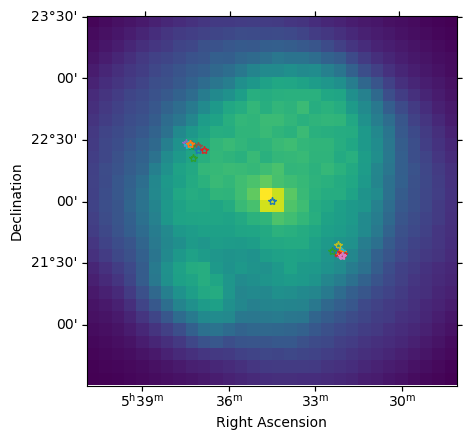

In [27]:
# Check the target position and OFF regions used for the calculation of the excess
ax = counts.plot(cmap="viridis", stretch="sinh")
on_geom.plot_region(ax=ax, kwargs_point={"color": "k", "marker": "*"})
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [28]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,10630,1319.0,9.34393678506387,9311.0,9970.5,9970.5,nan,952362.25,218927200.0,1198.620631637746,1273.2840201854704,8.868527471845368,7.768095888085817,1.1004315837595524,15,12,wstat,332.11194604402283,9311,12.0,12.0,1.0
stacked,21070,1974.0,9.851567495580527,19096.0,20083.0,20083.0,nan,1924526.75,442406528.0,2422.1639266164048,2566.86141753196,8.698833207970912,7.883859465563005,0.814973742407906,15,12,wstat,592.6886701471044,19096,12.0,12.0,1.0
stacked,31802,2946.0,11.963937357593291,28856.0,30329.0,30329.0,nan,2919189.25,671057600.0,3674.022591238584,3892.7339005470267,8.65590758092724,7.854061667669845,0.8018459132573941,15,12,wstat,851.8192715490351,28856,12.0,12.0,1.0
stacked,42971,3935.0,13.743668239323558,39036.0,41003.5,41003.5,nan,3813504.25,906467456.0,4896.6485190283,5185.235790252682,8.775594129947322,7.971983255140064,0.8036108748072587,15,12,wstat,1237.6214270034418,39036,12.0,12.0,1.0
stacked,48912,4773.0,15.650427854062965,44139.0,46525.5,46525.5,nan,4430759.0,1198682752.0,6181.8475535917205,6537.827927112576,7.912197700763682,7.140098428075077,0.7720992726886051,15,12,wstat,1524.3461028453064,44139,12.0,12.0,1.0
stacked,55017,5561.0,17.208915258841262,49456.0,52236.5,52236.5,nan,4827235.5,1493962496.0,7361.342855062825,7777.974485397333,7.473772256397703,6.718339435309174,0.7554328210885295,15,12,wstat,1728.5135252653872,49456,12.0,12.0,1.0
stacked,61940,6457.0,18.847933506149342,55483.0,58711.5,58711.5,nan,5060404.0,1823065984.0,8516.697175700996,8988.534893035878,7.272772381378209,6.514614627639767,0.758157753738442,15,12,wstat,2005.3922017864693,55483,12.0,12.0,1.0
stacked,65758,6718.0,19.021342130648733,59040.0,62399.0,62399.0,nan,5418302.5,1904897280.0,8967.139501078538,9469.141752719874,7.333219249247861,6.584039424489701,0.7491798247581607,15,12,wstat,2118.918285246076,59040,12.0,12.0,1.0


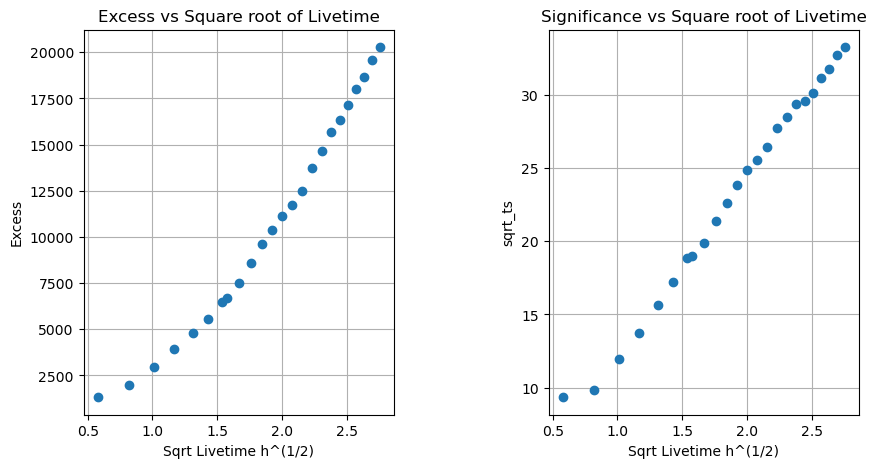

In [29]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["excess"], marker="o", ls="none"
)
plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Square root of Livetime')

plt.subplot(122)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Square root of Livetime')
plt.subplots_adjust(wspace=0.5)


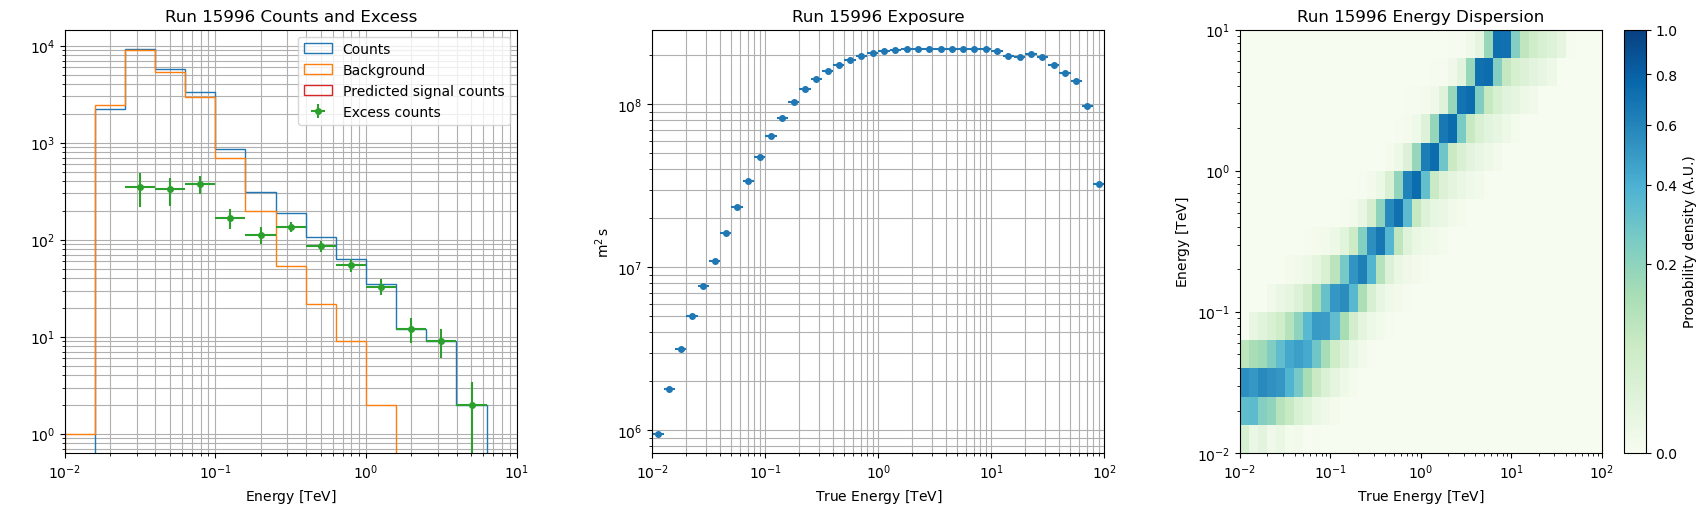

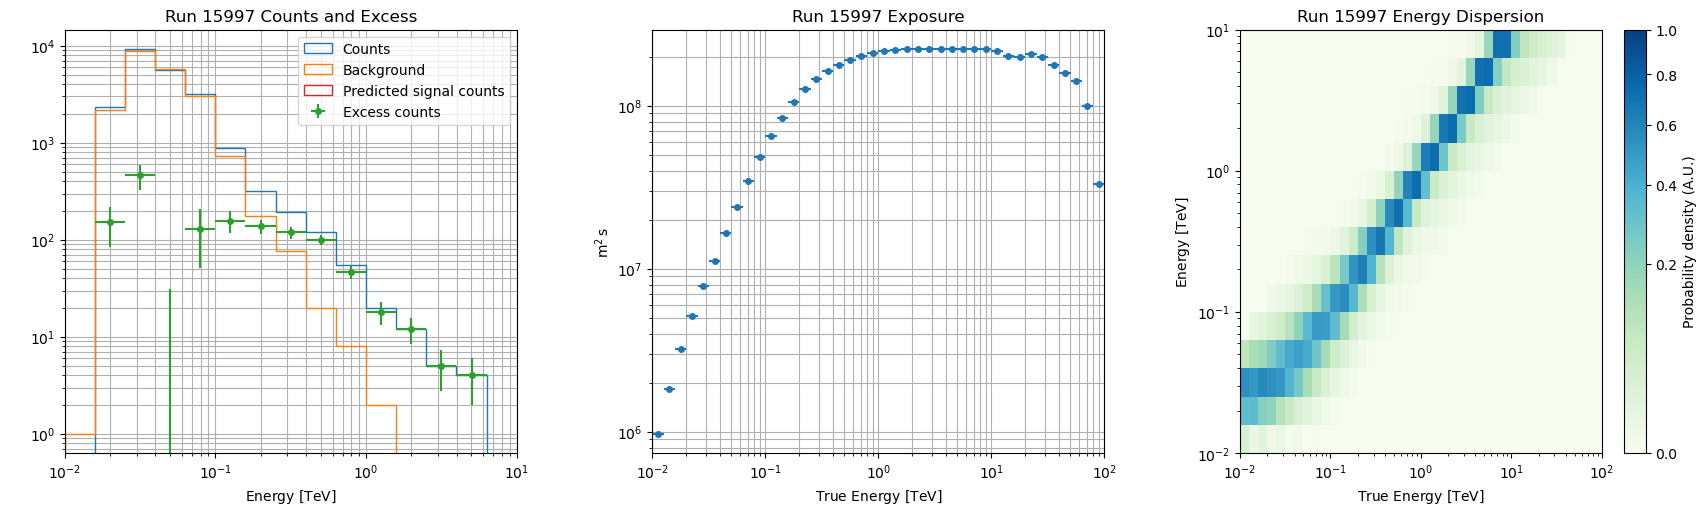

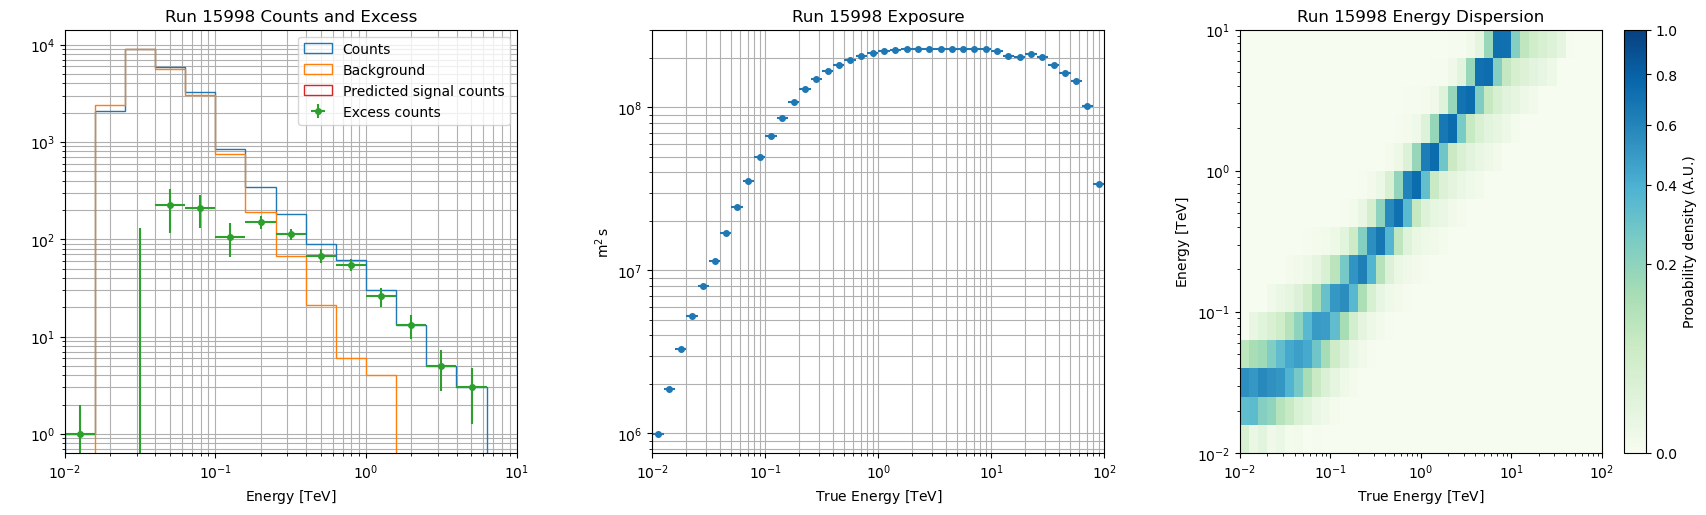

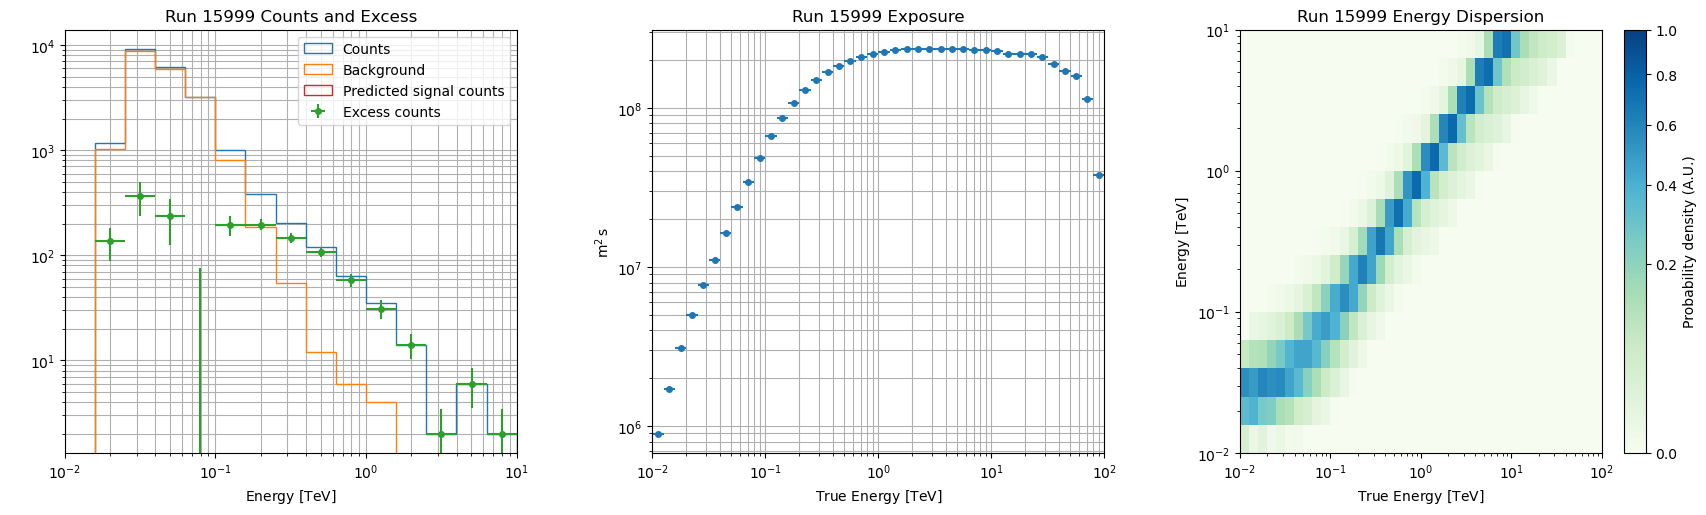

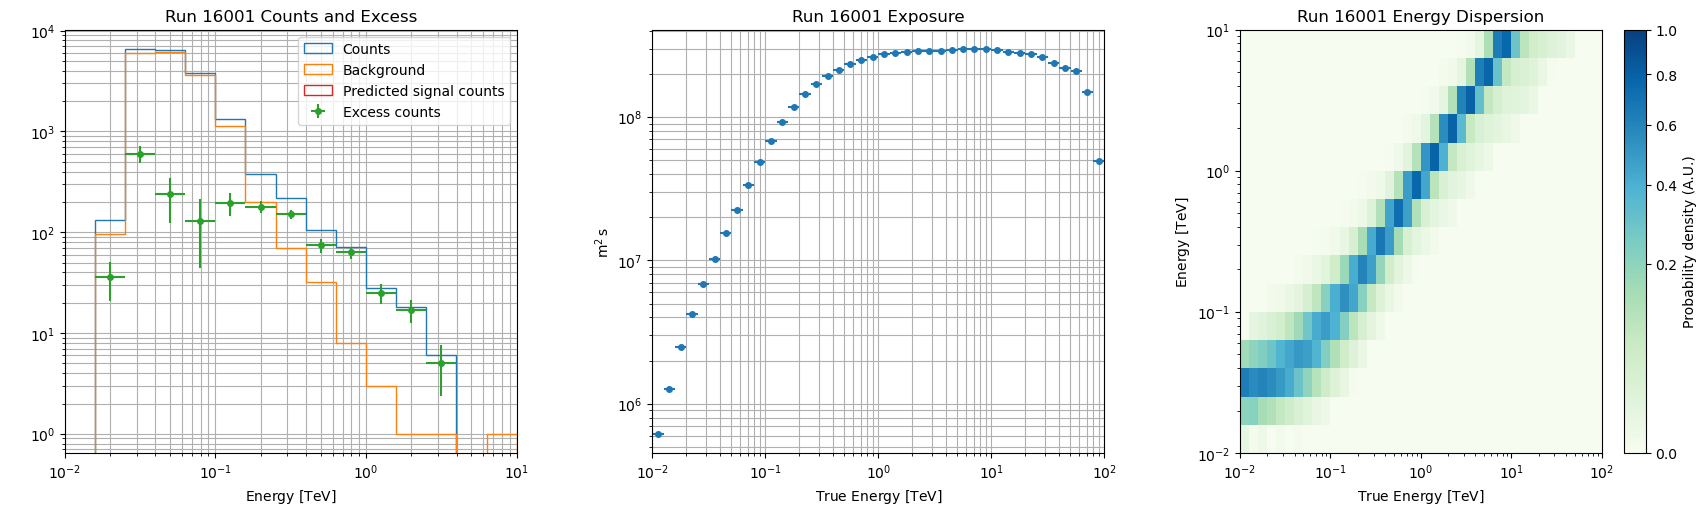

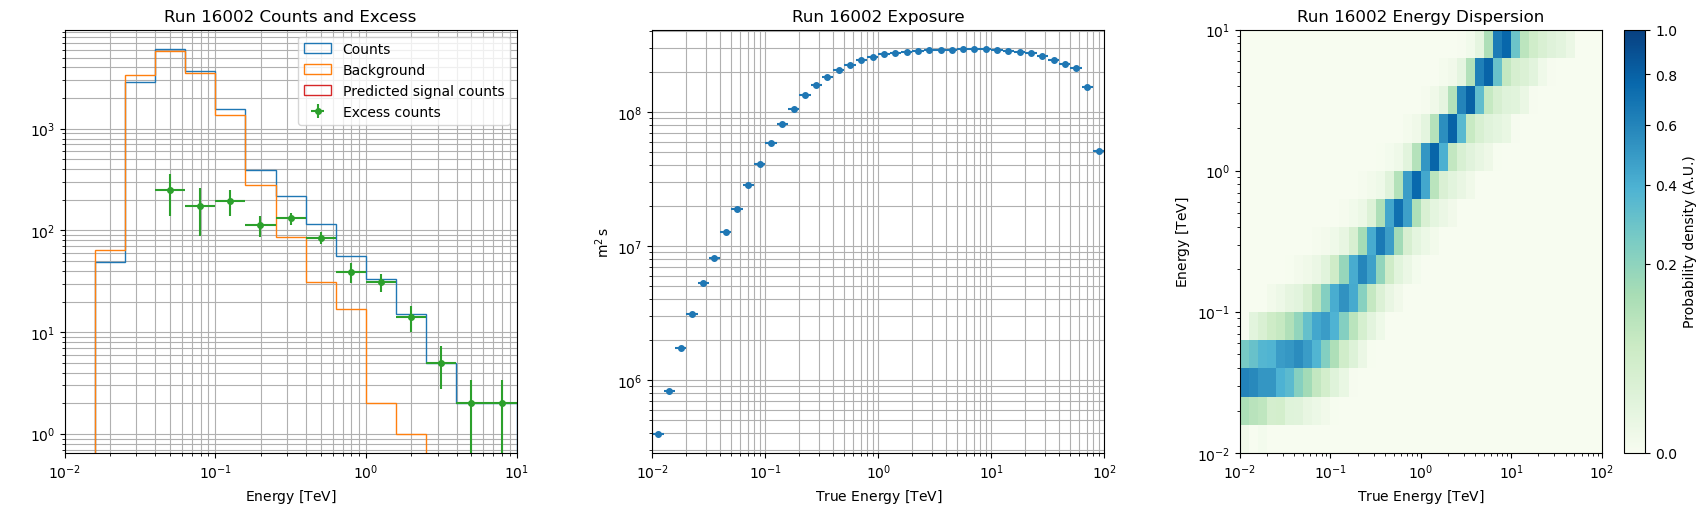

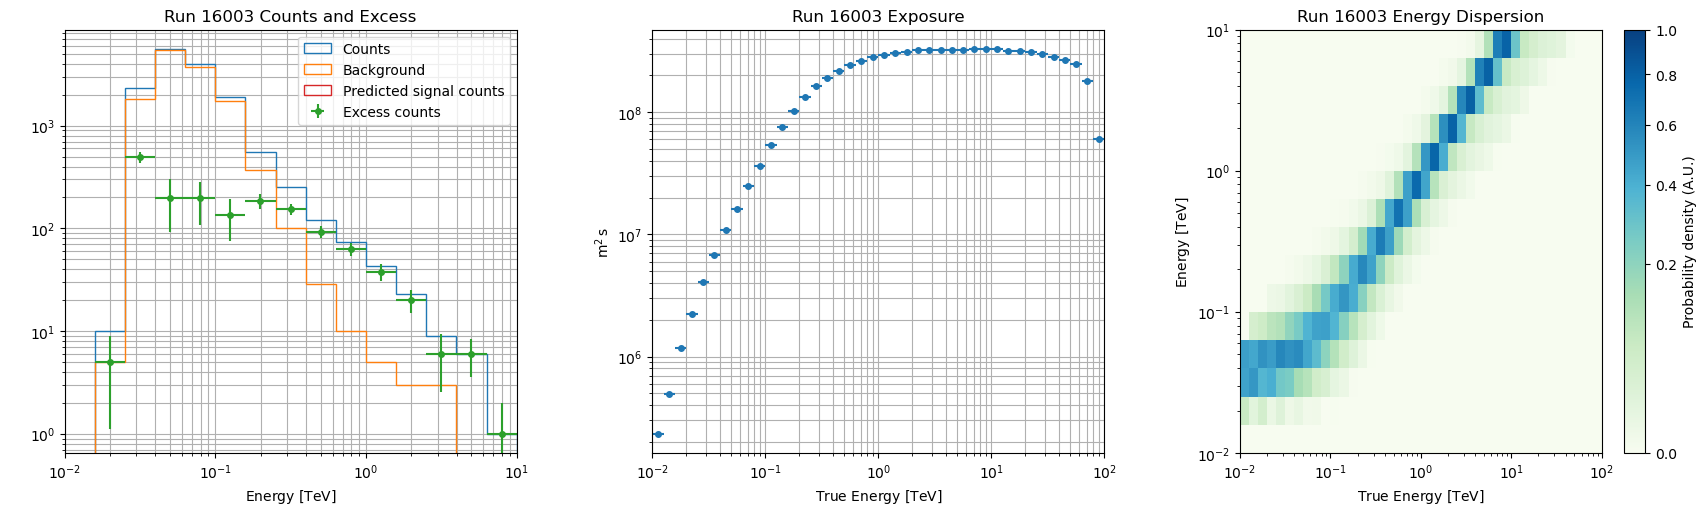

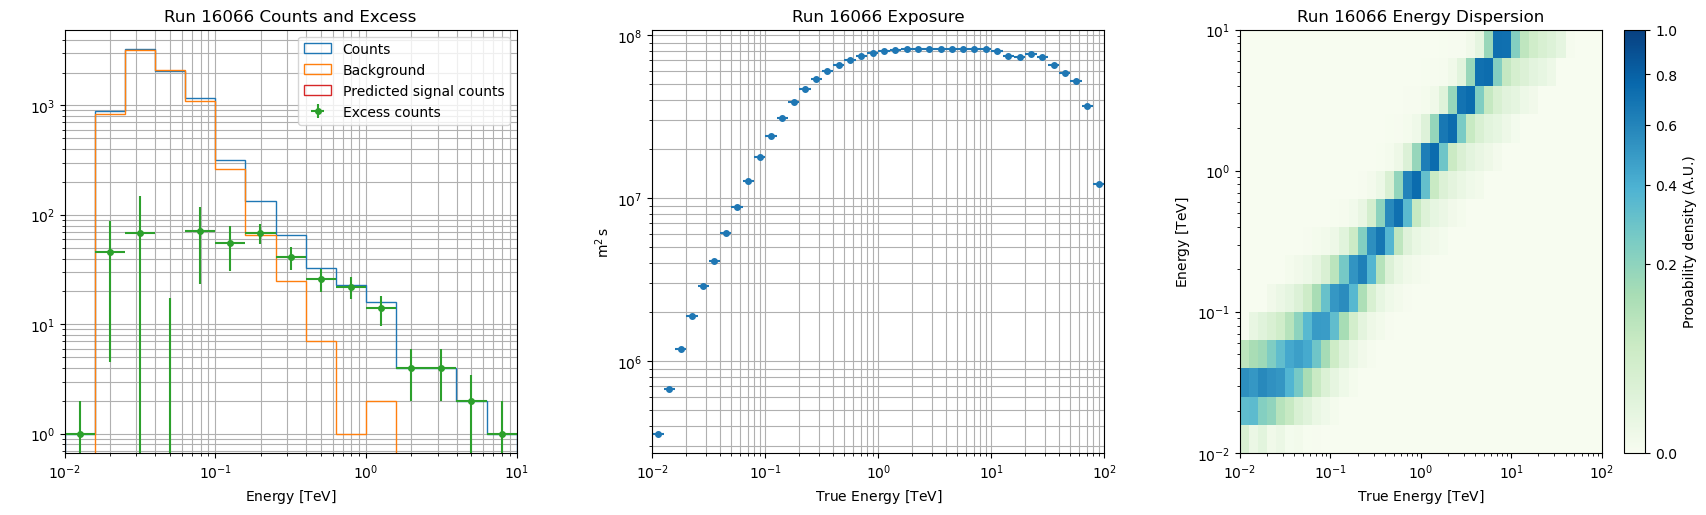

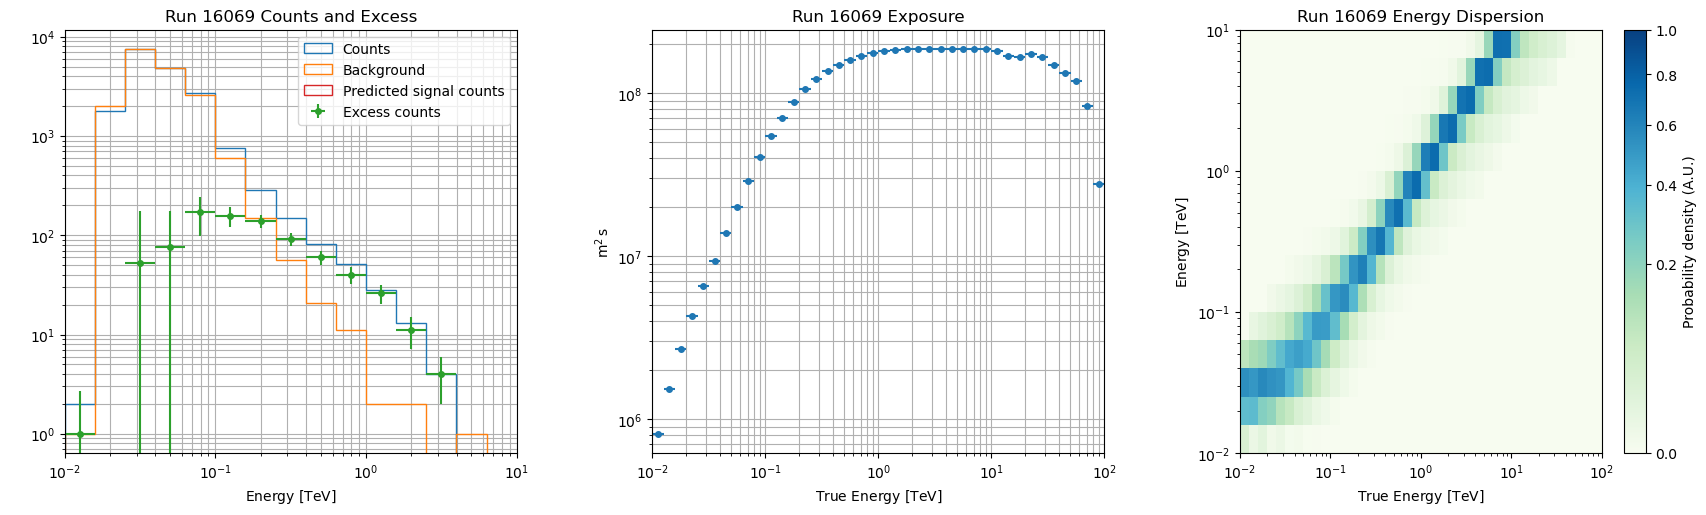

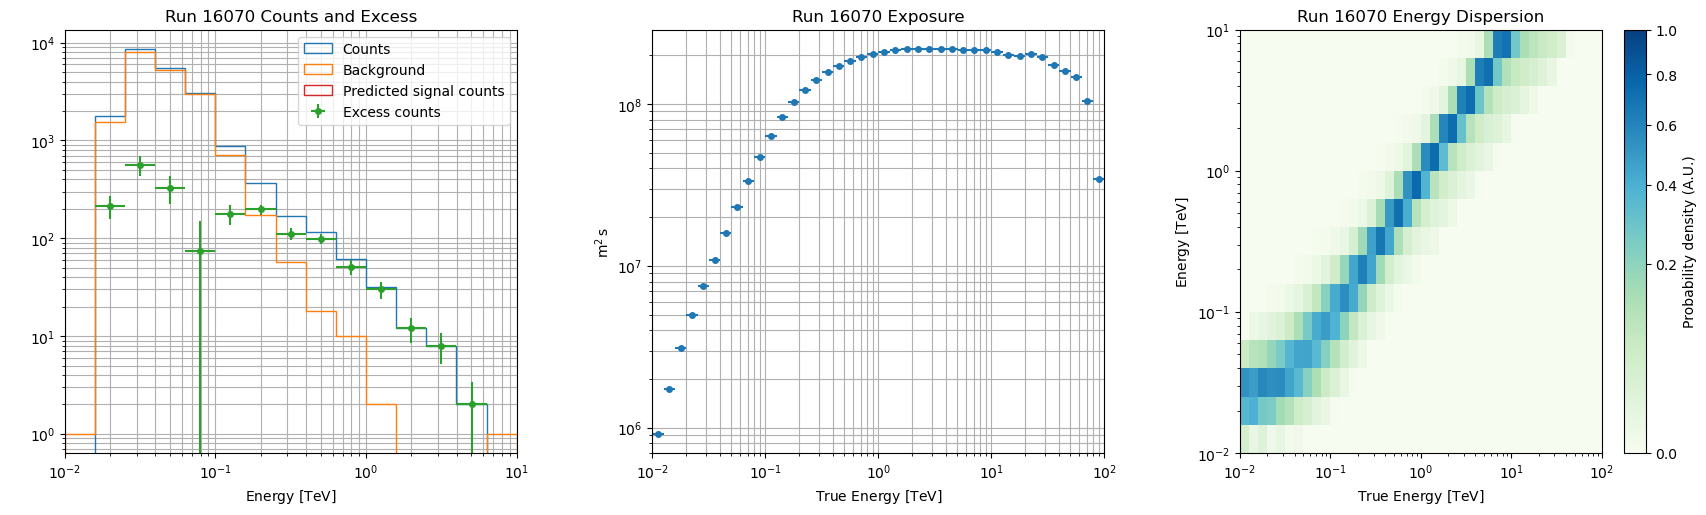

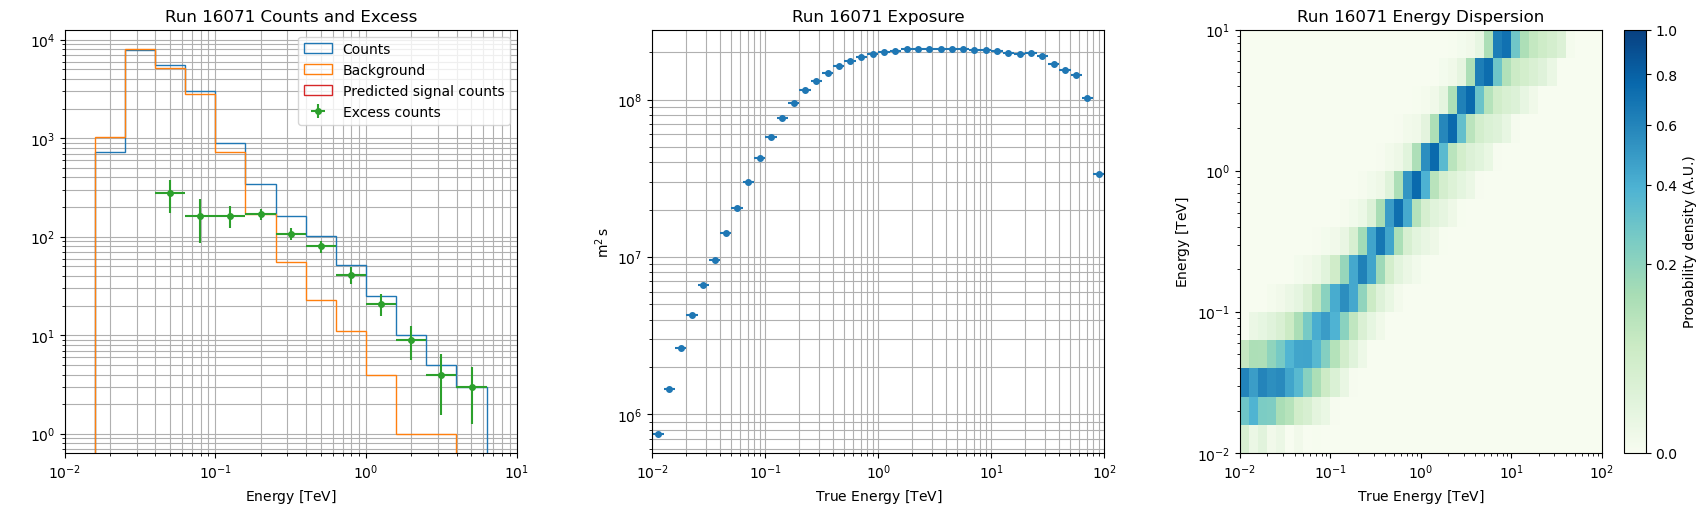

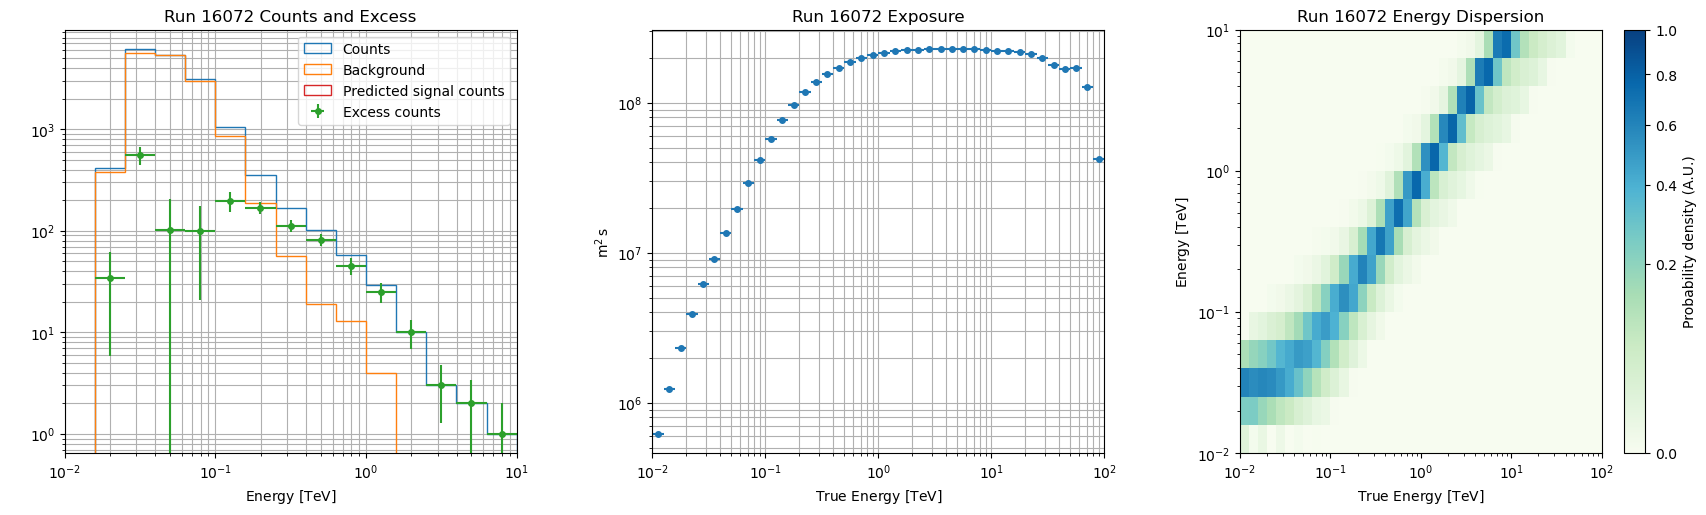

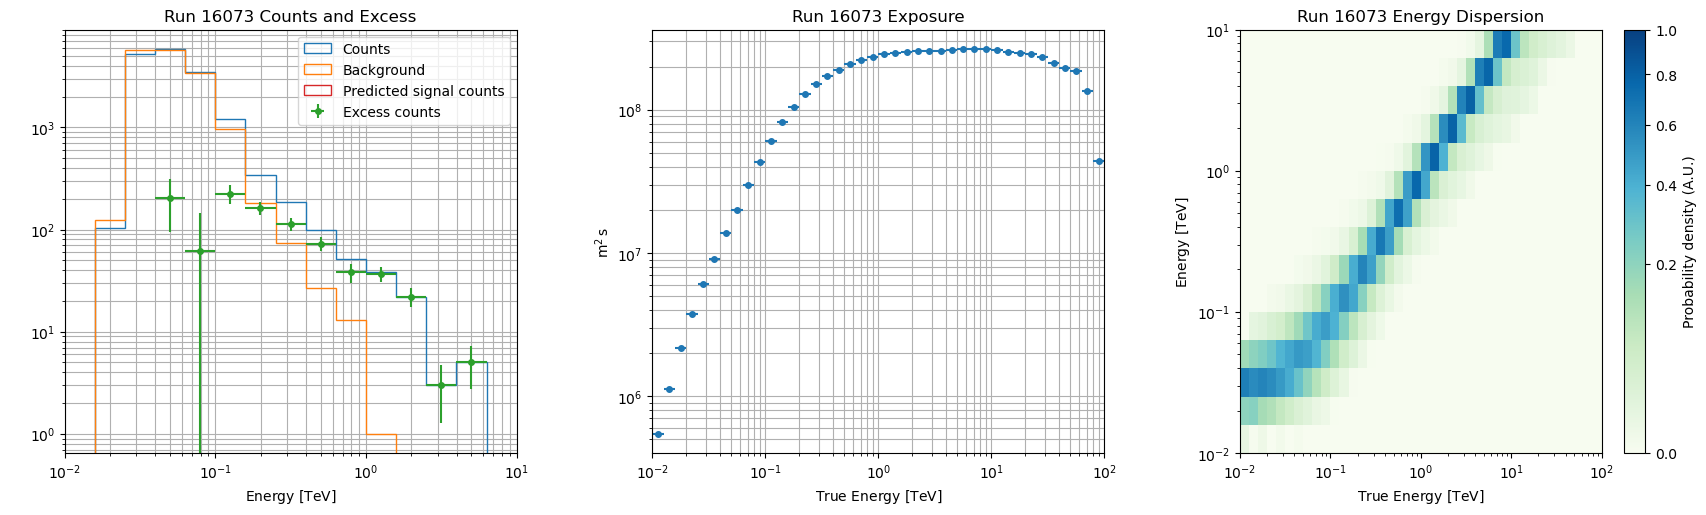

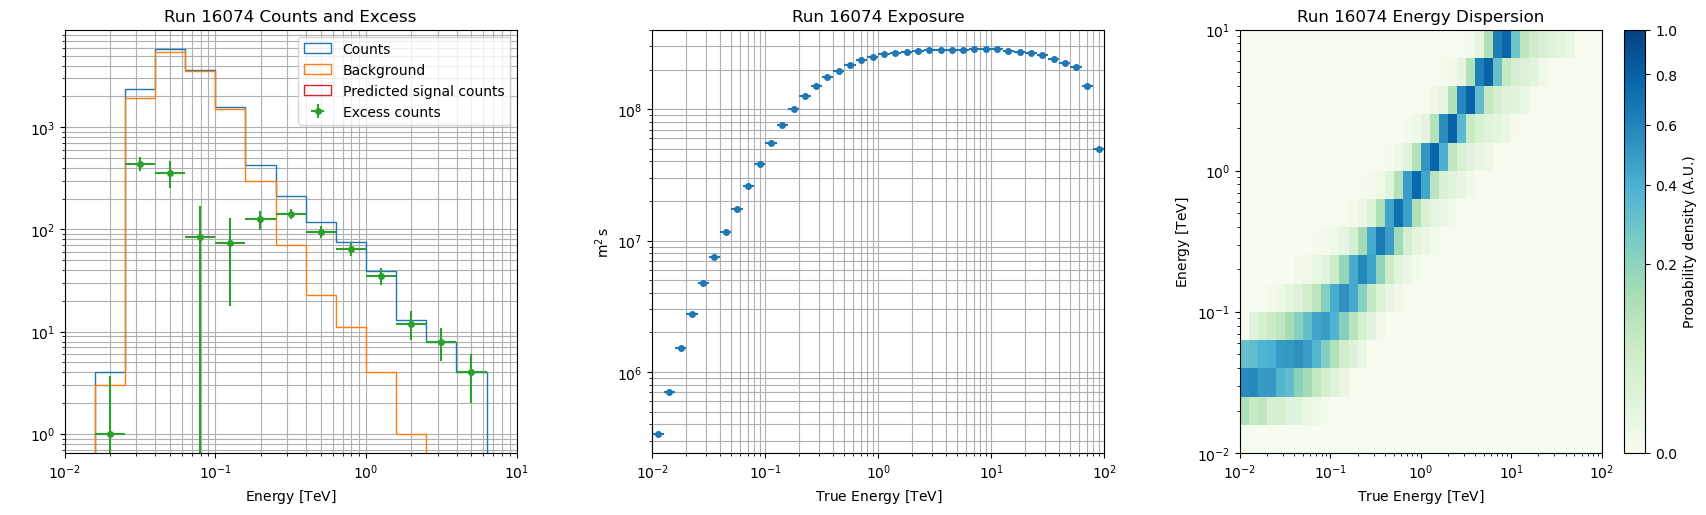

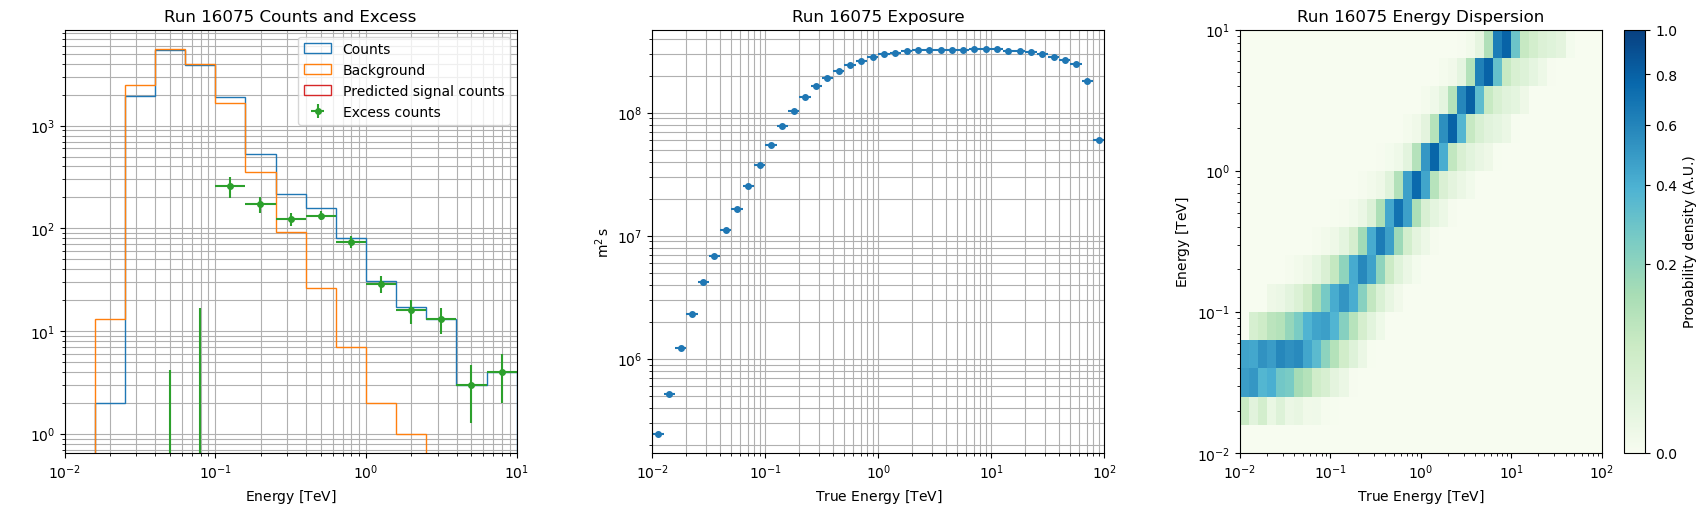

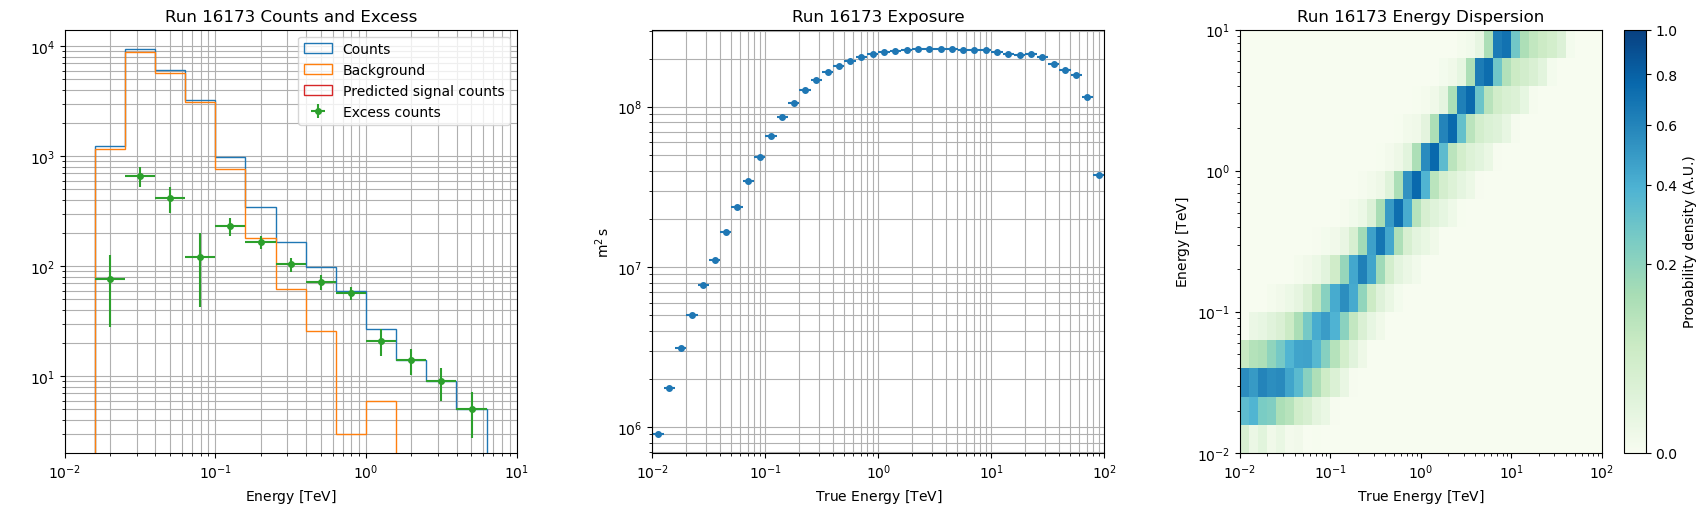

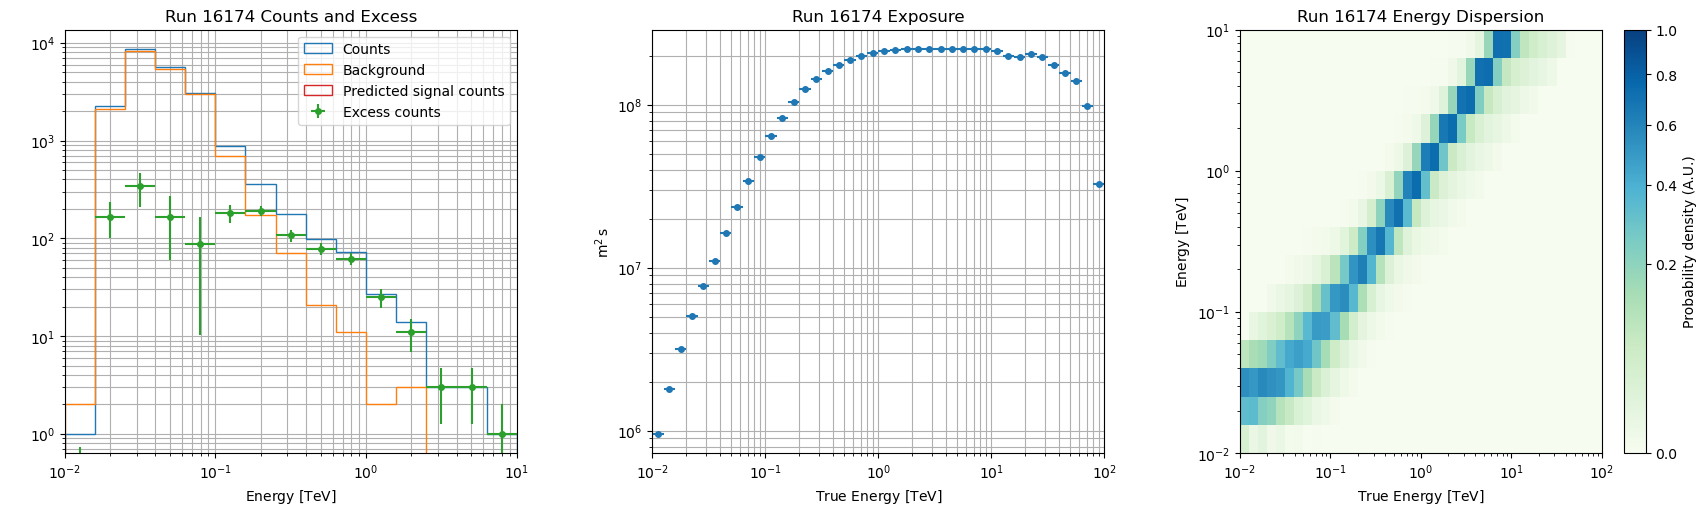

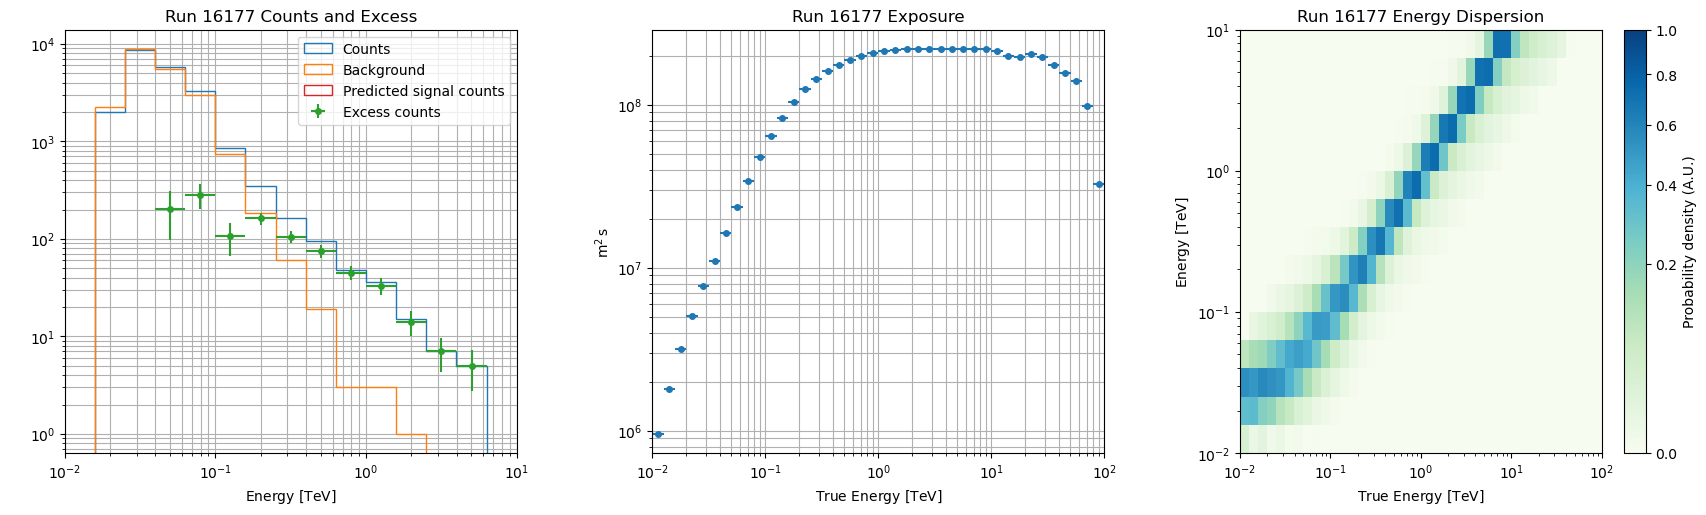

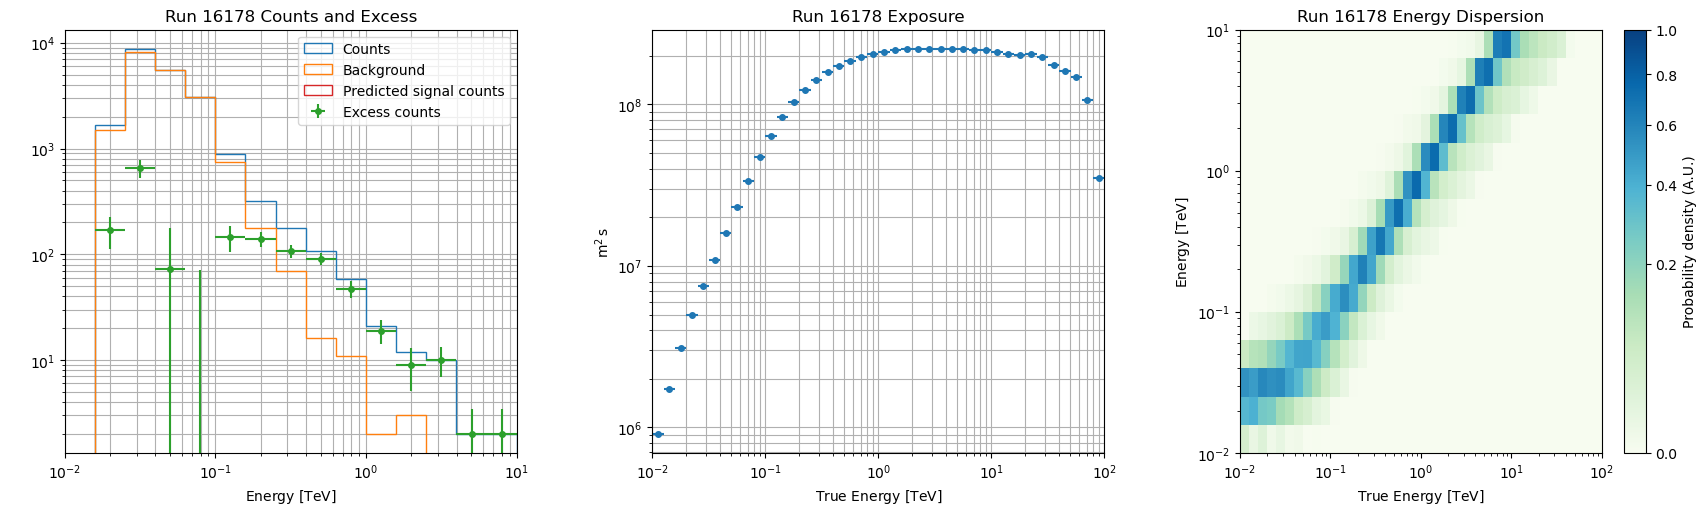

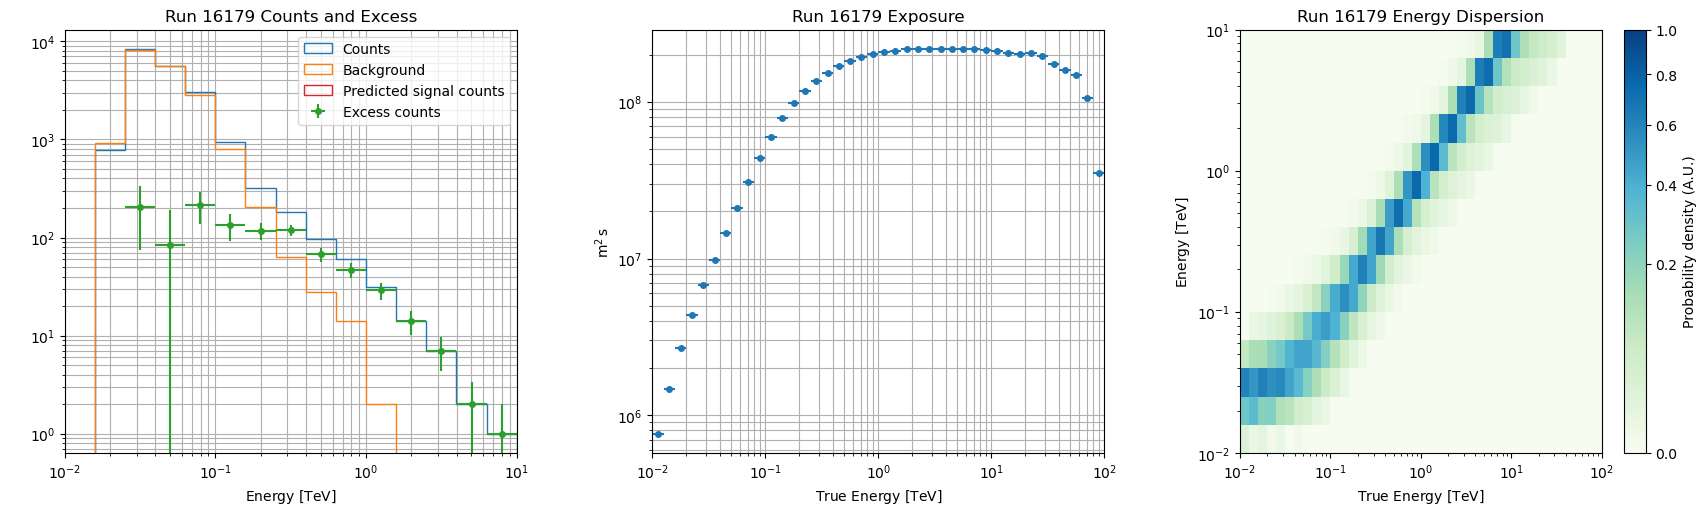

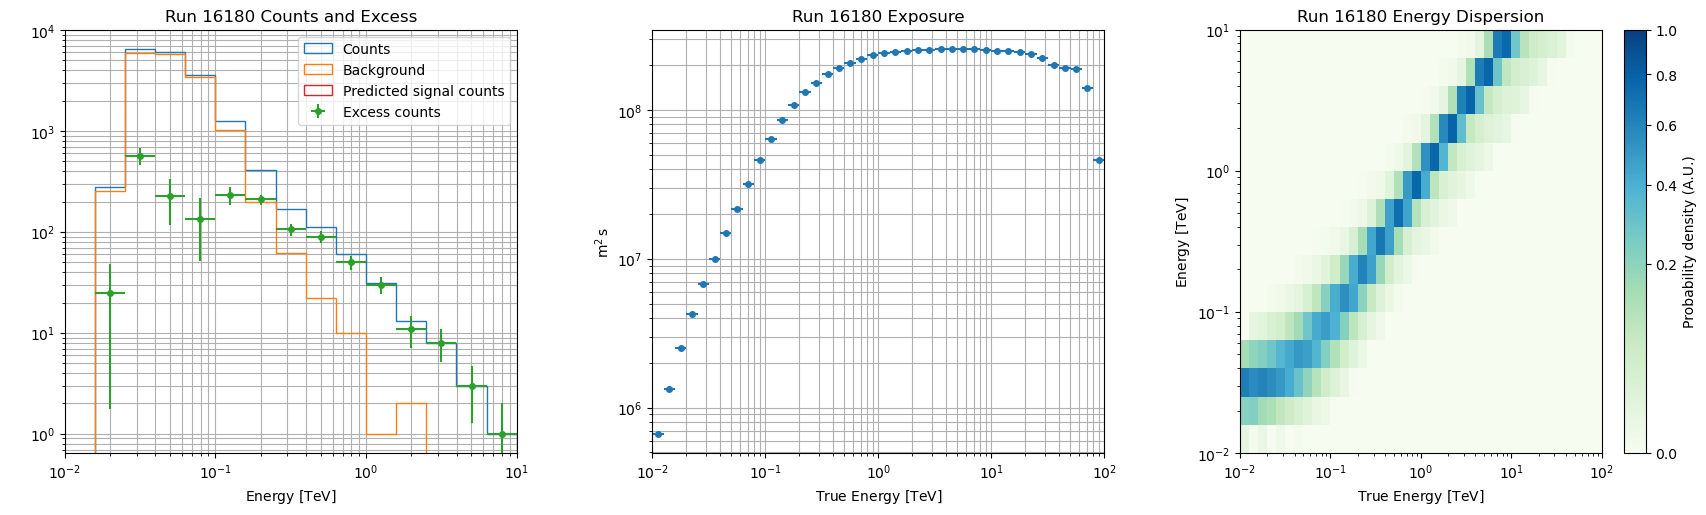

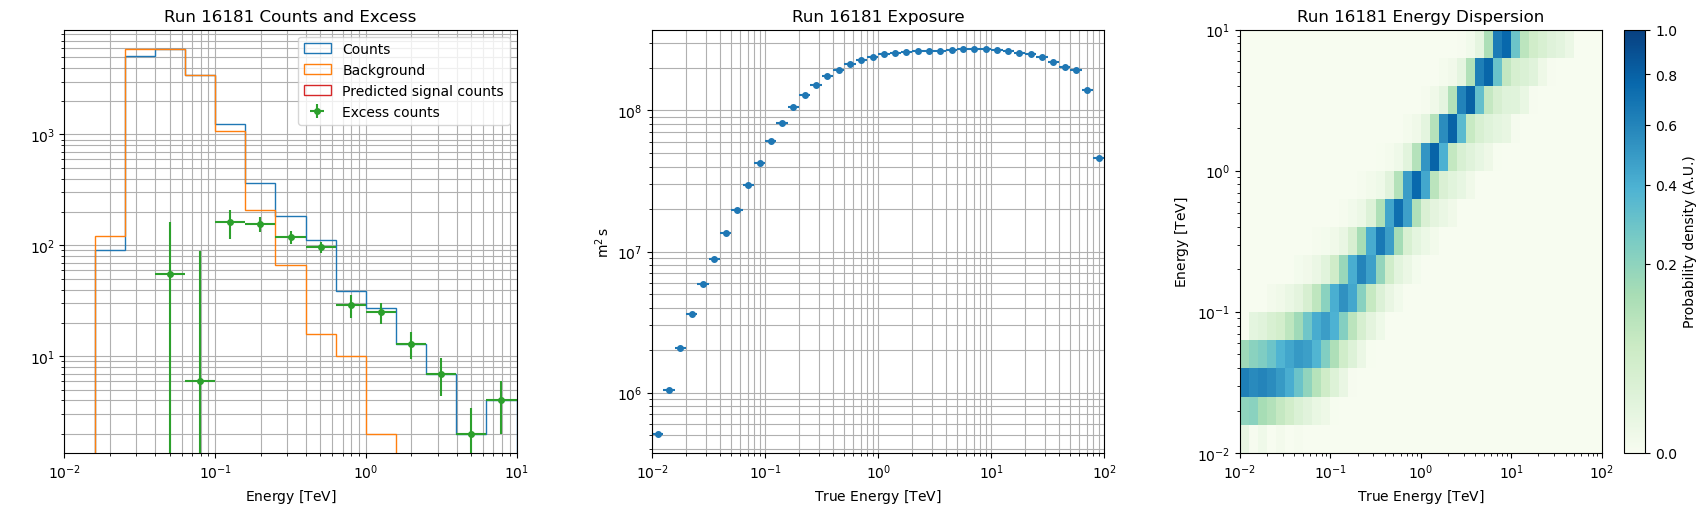

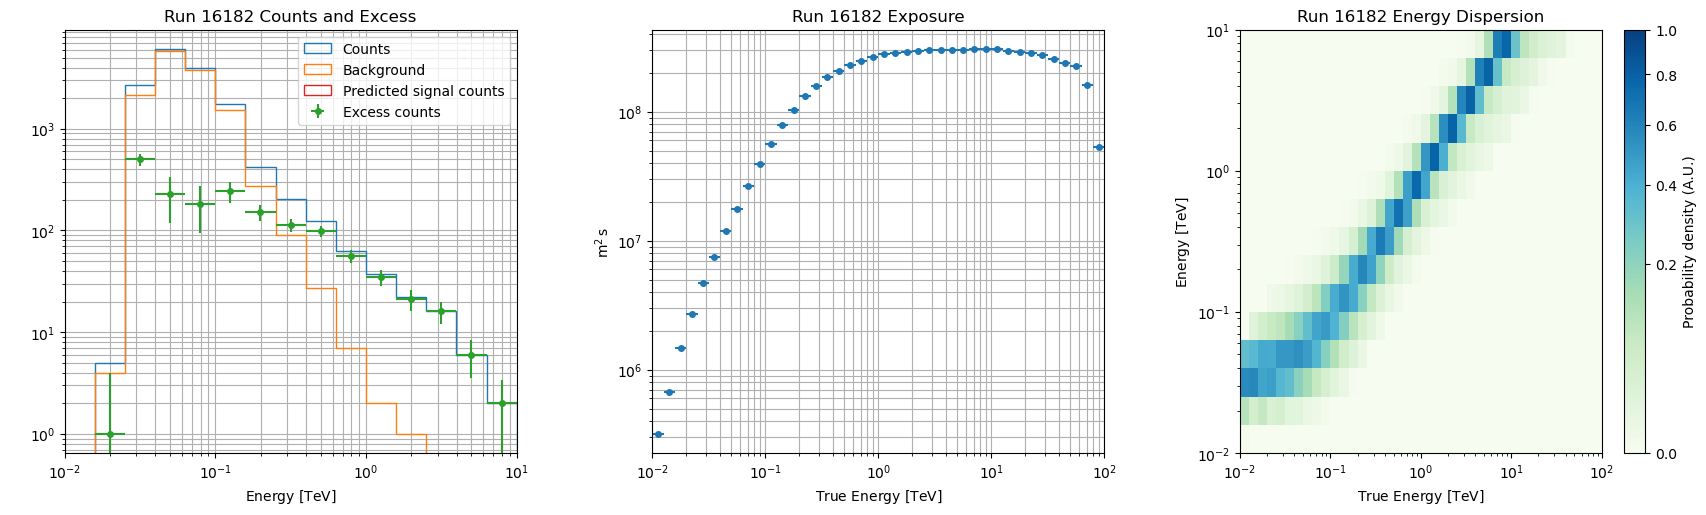

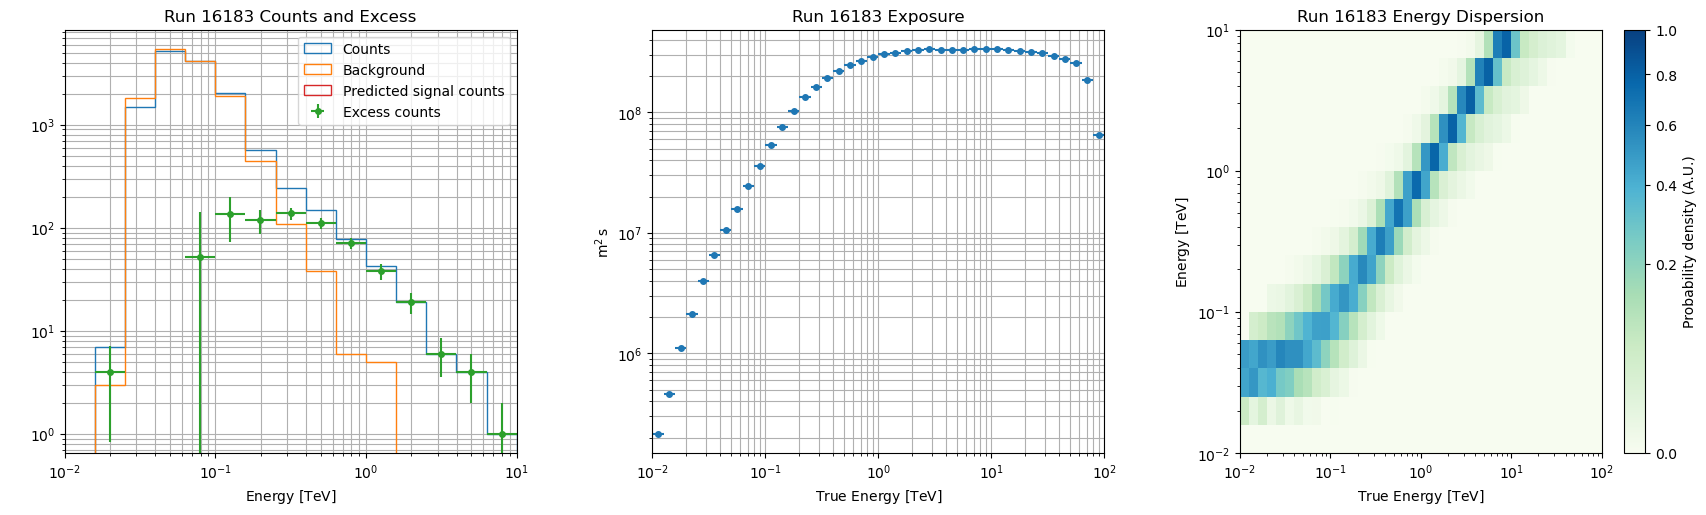

CPU times: user 46.7 s, sys: 6 s, total: 52.7 s
Wall time: 46.7 s


In [30]:
%%time
# Plot the counts+excess, exposure and energy migration of each selected dataset
for data in datasets:
    plt.figure(figsize=(21, 5.5))
    plt.subplot(131)
    data.plot_counts()
    data.plot_excess()
    plt.grid(which="both")
    plt.title(f'Run {data.name} Counts and Excess')
    
    plt.subplot(132)
    data.exposure.plot()
    plt.grid(which='both')
    plt.title(f'Run {data.name} Exposure')
    
    plt.subplot(133)
    if data.edisp is not None:
        kernel = data.edisp.get_edisp_kernel()
        kernel.plot_matrix(add_cbar=True)
        plt.title(f'Run {data.name} Energy Dispersion')
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    plt.close()

# 9. Write all datasets into OGIP files

In [31]:
for d in datasets:
    d.write(
        filename=ogip_path / f"obs_{d.name}.fits.gz", overwrite=True
    )

In [32]:
# Read the OGIP files to include the source object name in its headers, to be used for further analysis
for obs in obs_id_list:
    file = ogip_path/f"obs_{obs}.fits.gz"
    
    d1 = fits.open(file)
    d1.writeto(file, overwrite=True)

# 10. Get Pivot energy to fix the reference energy and define the Spectrum Model

In [33]:
# Find pivot (decorrelation) energy for a Power Law model to get the reference energy for Log Parabola model
def get_pivot_energy(datasets, e_ref, e_edges, obj_name):
    """
    Using Power Law spectral model with the given reference energy and 
    get the decorrelation energy of the fit, within the fit energy range, e_edges.
    This method is further explained in doi:10.1088/0004-637X/707/2/1310
    """
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=e_ref
    )
    model = SkyModel(spectral_model=spectral_model, name=obj_name)
    model_check = model.copy()

    # Stacked dataset method
    stacked_dataset = Datasets(datasets).stack_reduce()
    stacked_dataset.models = model_check

    fit_stacked = Fit()
    result_stacked = fit_stacked.run(datasets=stacked_dataset)

    return model_check.spectral_model.pivot_energy


In [42]:
# Using a reference energy close to the expected decorrelation energy
ref = get_pivot_energy(datasets, 1.* u.TeV, energy_axis.edges, obj_name)
print(ref.to_value(u.GeV))
# For some reason, it gives an error when passing the argument e_ref = 1.*u.TeV

/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:189: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88:

nan


/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:189: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:189: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)
/fefs/aswg/software/conda/envs/lst-school-2024-02/lib/python3.11/site-packages/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow enc

In [43]:
print(ref)

nan TeV


In [73]:
# Final spectral model of Log Parabola, to be used for estimating the LC.
# One can try different Spectral Models as well.
# Be careful in the choice of Spectral Model being used for the 2 examples presented here

# Crab
spectral_model_lp = LogParabolaSpectralModel(
        amplitude = 5e-12 * u.Unit('cm-2 s-1 TeV-1'),
        reference = ref,
        alpha = 2 * u.Unit(''),
        beta = 0.1 * u.Unit('')
)
model_lp = SkyModel(spectral_model=spectral_model_lp, name=obj_name)
print(model_lp)

SkyModel

  Name                      : CrabNebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   5.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      0.455       TeV         
    alpha                         :      2.000   +/-    0.00             
    beta                          :      0.100   +/-    0.00             




In [72]:
# Use the appropriate models, as per the selection of the source/dataset
params=model_lp.to_dict()['spectral'] 
params

{'type': 'LogParabolaSpectralModel',
 'parameters': [{'name': 'amplitude',
   'value': 5e-12,
   'unit': 'TeV-1 s-1 cm-2'},
  {'name': 'reference', 'value': 0.4552799820934606, 'unit': 'TeV'},
  {'name': 'alpha', 'value': 2.0},
  {'name': 'beta', 'value': 0.1}]}

# 11. Spectral Fitting
One can check for a more comprehensive tutorial on Modelling and Fitting in the Gammapy tutorials
* https://docs.gammapy.org/1.1/tutorials/api/fitting.html
* https://docs.gammapy.org/1.1/tutorials/api/model_management.html

In [79]:
# Using stacked analysis method, where we stack together all Datasets into 1 Dataset and add the model afterwards
stacked_dataset = Datasets(datasets).stack_reduce()
stacked_dataset.models = model_lp

# NB! with this assignment we are creating an *alias* for model_lp, i.e. model_lp and stacked_dataset.models refer to the same object in memory.
# so when we modify stacked_dataset.models, e.g. by fitting, we also modify model_lp

In [81]:
# Fitting the model to the dataset
fit = Fit()
result = fit.run(datasets=stacked_dataset)
model_best = model_lp

In [82]:
# Compute the Flux Points after Fitting the model
# We do not do too many optimizations here. 
# If one wants, can try and check the various attributes of the Estimator
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    reoptimize = False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name,
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)
flux_points = fpe.run(datasets=stacked_dataset)

flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best
)

In [83]:
# Create the LC Estimator on a run-by-run basis and nightly
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name, 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

lc_maker_night_wise = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    time_intervals=t_range,
    reoptimize=False, 
    source=obj_name,
    selection_optional="all"
)

# Assigning the best fit model for each dataset
for data in datasets:
    data.models = model_best

In [84]:
lc_1d = lc_maker_1d.run(datasets)
lc_night = lc_maker_night_wise.run(datasets)

In [86]:
result

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 37
	total stat : 11.91

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [87]:
model_best.to_dict()['spectral']['parameters']

[{'name': 'amplitude',
  'value': 2.6041719989510063e-10,
  'unit': 'TeV-1 s-1 cm-2',
  'error': 4.207878144855045e-12},
 {'name': 'reference', 'value': 0.4552799820934606, 'unit': 'TeV'},
 {'name': 'alpha', 'value': 2.289446042683572, 'error': 0.017780748194805397},
 {'name': 'beta', 'value': 0.12139084896611514, 'error': 0.013621529946941437}]

# 12. Check some features of the Flux points

In [88]:
# Check the Flux table
# sed_type options are {“likelihood”, “dnde”, “e2dnde”, “flux”, “eflux”} with "likelihood" being default
# format options are {“gadf-sed”, “lightcurve”, “binned-time-series”, “profile”} with "gadf-sed" being default
flux_points.to_table(formatted=True, sed_type="e2dnde")

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.020,0.016,0.025,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.032,0.025,0.040,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.050,0.040,0.063,8.596e-11,1.396e-11,1.396e-11,1.396e-11,1.139e-10,37.902,6.156,70145.9971194282,2286.9944,0.000,False,70146.0,True,0.200 .. 5.000,28.575 .. 199.022
0.079,0.063,0.100,5.318e-11,7.130e-12,7.132e-12,7.132e-12,6.744e-11,55.599,7.456,79152.98180440709,2938.9644,0.000,False,79153.0,True,0.200 .. 5.000,32.757 .. 1279.960
0.126,0.100,0.158,6.698e-11,3.775e-12,3.775e-12,3.774e-12,7.453e-11,315.209,17.754,27829.977217538464,4031.9578,0.000,False,27830.0,True,0.200 .. 5.000,206.188 .. 4273.980
0.200,0.158,0.251,6.308e-11,2.034e-12,2.035e-12,2.032e-12,6.715e-11,973.020,31.193,8919.000026065407,3689.0,0.000,False,8919.0,True,0.200 .. 5.000,624.638 .. 10720.365
0.316,0.251,0.398,5.694e-11,1.583e-12,1.586e-12,1.580e-12,6.012e-11,1344.510,36.668,4463.004928341359,2813.0068,0.000,False,4463.0,True,0.200 .. 5.000,854.166 .. 11426.015
0.501,0.398,0.631,5.370e-11,1.472e-12,1.478e-12,1.466e-12,5.668e-11,1446.830,38.037,2584.6094460506242,2040.5272,0.000,False,2585.0,True,0.200 .. 5.000,959.563 .. 8386.967


In [89]:
# Check the various column data of the Light Curve object
lc_1d.to_table(sed_type="flux", format="lightcurve")

time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (s cm2),1 / (s cm2),1 / (s cm2),1 / (s cm2),1 / (s cm2),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,24]","float64[1,24]",float64[1],bool[1],"float64[1,24]",bool[1],"float64[1,11]","float64[1,11]"
60290.04492940321,60290.05966648678,1.0000000000000002,0.10000000000000002,10.000000000000002,5.654017158912673e-10,3.402847309692549e-11,3.42846904619861e-11,3.378211674807138e-11,6.345074208288225e-10,289.32164993132267,17.009457661293105,1607.213109788107 .. nan,642.4298095703125 .. nan,10.498431746313187,False,1593.0 .. nan,True,0.2 .. 4.999999999999999,201.3428848016902 .. 2156.814485863635
60290.05993432985,60290.07490629047,1.0000000000000002,0.10000000000000002,10.000000000000002,5.247196426941407e-10,3.370842168486667e-11,3.396118668407345e-11,3.346043410823981e-11,5.931222158439786e-10,264.9765129906284,16.278099182356286,nan .. nan,nan .. nan,8.698859882956263,False,nan .. nan,True,0.2 .. 4.999999999999999,175.5817088912684 .. 2266.5021374869107
60290.075159207365,60290.090504953696,1.0000000000000002,0.10000000000000002,10.000000000000002,4.894201848590806e-10,3.21518789509811e-11,3.2410913778976577e-11,3.190183474160882e-11,5.547805536448915e-10,246.7033367878799,15.706792695769556,nan .. nan,nan .. nan,6.062833298980227,False,nan .. nan,True,0.2 .. 4.999999999999999,156.71849945673202 .. 2429.4395190298605
60290.0907594066,60290.105718919214,1.0000000000000002,0.10000000000000002,10.000000000000002,6.851090979449022e-10,3.63837796890407e-11,3.6677956012561144e-11,3.609675576659451e-11,7.590758090692805e-10,390.8890373390008,19.770913922704757,nan .. nan,nan .. nan,8.911924155000673,False,nan .. nan,True,0.2 .. 4.999999999999999,286.75143018827816 .. 1812.9948170426364
60290.12165605774,60290.13731105932,1.0000000000000002,0.10000000000000002,10.000000000000002,5.452925558321987e-10,3.366727556763492e-11,3.391144666053461e-11,3.343146514045563e-11,6.136134508968306e-10,284.2156911012064,16.858697787824727,nan .. nan,nan .. nan,16.571054088735742,False,nan .. nan,True,0.2 .. 4.999999999999999,198.21069488901372 .. 2275.0033360354637
60290.1375475513,60290.15190109942,1.0000000000000002,0.10000000000000002,10.000000000000002,4.98748222296789e-10,3.5125310450499195e-11,3.540652028887552e-11,3.484420852510566e-11,5.699708526366504e-10,218.33595805954636,14.77619565583599,nan .. nan,nan .. nan,6.166404378261808,False,nan .. nan,True,0.2 .. 4.999999999999999,139.42875375906416 .. 2115.0878693445457
60290.15214686499,60290.16615798081,1.0000000000000002,0.10000000000000002,10.000000000000002,5.966203058493152e-10,3.6481477374221206e-11,3.676989818186446e-11,3.6202888380599734e-11,6.707609601545332e-10,288.0631364385934,16.972422821700896,nan .. nan,nan .. nan,3.2759777331190594,False,nan .. nan,True,0.2 .. 4.999999999999999,195.9959430401983 .. 1906.7614135655176
60292.02951891906,60292.035081498456,1.0000000000000002,0.10000000000000002,10.000000000000002,5.7454782546431e-10,5.5442668474086846e-11,5.623055124643855e-11,5.495501802247686e-11,6.886433456112227e-10,113.66919182362265,10.661575485059544,nan .. nan,nan .. nan,5.472992893736733,False,nan .. nan,True,0.2 .. 4.999999999999999,80.61559117690572 .. 802.9203072877085


In [90]:
# If there are more than 1 night of data, one can see the integrated light curve for each night
lc_night.to_table(sed_type="flux", format="lightcurve")

time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (s cm2),1 / (s cm2),1 / (s cm2),1 / (s cm2),1 / (s cm2),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,24]","float64[1,24]",float64[1],bool[1],"float64[1,24]",bool[1],"float64[1,11]","float64[1,11]"
60289.50080074074,60290.50080074074,1.0000000000000002,0.10000000000000002,10.000000000000002,5.562019115139351e-10,1.3055019984667924e-11,1.309311474979966e-11,1.3019142411117049e-11,5.825658367480389e-10,1960.2363310714466,44.2745562492889,1599.7638155525851 .. nan,631.9766235351562 .. nan,82.4544768600985,False,1593.0 .. nan,True,0.2 .. 4.999999999999999,1354.029915026245 .. 14962.603578368566
60291.50080074074,60292.50080074074,1.0000000000000002,0.10000000000000002,10.000000000000002,5.89126963360975e-10,1.3625104108107139e-11,1.3665294098547051e-11,1.358542555441604e-11,6.165421208056177e-10,2022.1137151820908,44.967918733048904,nan .. nan,nan .. nan,84.61444836043297,False,nan .. nan,True,0.2 .. 4.999999999999999,1431.2709452881236 .. 13681.865112590589
60294.50080074074,60295.50080074074,1.0000000000000002,0.10000000000000002,10.000000000000002,5.629477091297404e-10,1.1808927489558235e-11,1.1841979371431771e-11,1.1777778677407735e-11,5.867135003714343e-10,2454.8057810580276,49.545996619888754,nan .. 3182.914289207974,nan .. 682.3346557617188,83.07677837073865,False,nan .. 3167.0,True,0.2 .. 4.999999999999999,1688.6508792143002 .. 18093.735757936454


In [95]:
# Fit Statistic array
print(flux_points_dataset.stat_array())

# Total statistics sum
print(flux_points_dataset.stat_sum(), np.nansum(flux_points_dataset.stat_array()))

[           nan            nan 4.41831210e+00 1.46294425e+00
 5.91537392e-01 1.61946109e-04 1.73908559e+00 7.31632558e-01
 3.27661301e-02 2.04797509e-01 2.33968926e-01 4.38549375e-04
 5.10626031e-01 2.27463446e+00]
nan 12.200905447590054


In [96]:
# Add the Fit results to the model object to save it to file
model_final = model_best.to_dict()
model_final["FitResult"] = {
    "Optimize": result.optimize_result,
    "Covariance": result.covariance_result
}

In [97]:
model_final

{'name': 'CrabNebula',
 'type': 'SkyModel',
 'spectral': {'type': 'LogParabolaSpectralModel',
  'parameters': [{'name': 'amplitude',
    'value': 2.6041719989510063e-10,
    'unit': 'TeV-1 s-1 cm-2',
    'error': 4.207878144855045e-12},
   {'name': 'reference', 'value': 0.4552799820934606, 'unit': 'TeV'},
   {'name': 'alpha',
    'value': 2.289446042683572,
    'error': 0.017780748194805397},
   {'name': 'beta',
    'value': 0.12139084896611514,
    'error': 0.013621529946941437}]},
 'FitResult': {'Optimize': OptimizeResult
  
  	backend    : minuit
  	method     : migrad
  	success    : True
  	message    : Optimization terminated successfully..
  	nfev       : 37
  	total stat : 11.91
  ,
  'Covariance': CovarianceResult
  
  	backend    : minuit
  	method     : hesse
  	success    : True
  	message    : Hesse terminated successfully.}}

In [98]:
model_best.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,amplitude,2.6042e-10,TeV-1 s-1 cm-2,4.208e-12,nan,nan,False,True,
spectral,reference,4.5528e-01,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,2.2894e+00,,1.778e-02,nan,nan,False,False,
spectral,beta,1.2139e-01,,1.362e-02,nan,nan,False,False,


# 13. Plots

In [99]:
ref_label="Crab MAGIC LP (JHEAp 2015)"

In [102]:
# Setting plot axes limits and other args

# Here we plot only in the energy range from where we have the first flux point, and before the first UL.
# This is based on the selection we used earlier on the dataset and the Flux points estimation we get.
# One should adjust the limit as per selections used earlier.

positive_flux = flux_points.to_table(formatted=True, sed_type="e2dnde")["e2dnde"] > 0
e_plot_min = flux_points.to_table(formatted=True, sed_type="e2dnde")["e_min"].quantity[positive_flux][0]

non_ul = flux_points.to_table(formatted=True, sed_type="e2dnde")["is_ul"] == 0
e_plot_max = flux_points.to_table(formatted=True, sed_type="e2dnde")["e_max"].quantity[non_ul][-1]

sed_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [e_plot_min, e_plot_max],
}

# Using the energy range used in the MAGIC reference
ds_magic_ref_kwargs = {
    "sed_type": "dnde",
    "energy_bounds": [50 * u.GeV, 30 * u.TeV],
}
sed_magic_ref_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [50 * u.GeV, 30 * u.TeV],
}
lc_kwargs = {
    "marker": "o", 
    "label": "LST-1"
}
sed_plot_kwargs = {
    "label": "LST-1 data",
}
plot_ts_kwargs = {
    "color": "darkorange"
}

In [103]:
# Calculate & plot Crab reference flux
# https://doi.org/10.1016/j.jheap.2015.01.002
crab = create_crab_spectral_model("magic_lp")
crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)

flux_crab, flux_crab_error = crab.integral_error(e_lc_min, e_lc_max)
print(flux_crab, flux_crab_error)

4.758494064125543e-10 1 / (s cm2) 1.0322282551505248e-11 1 / (s cm2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


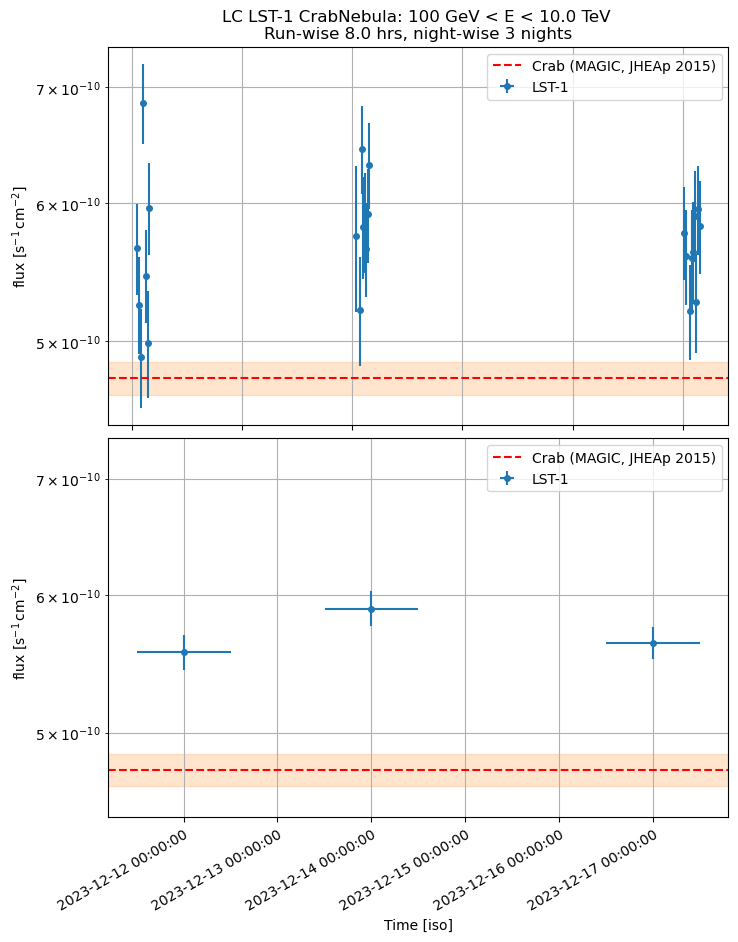

In [104]:
fig_lc = plt.figure(figsize=(8,10))

gs2 = GridSpec(10, 5)

gs2.update(wspace=0.4)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_lc.add_subplot(*args1)
fig_gs2 = fig_lc.add_subplot(*args2, sharey=fig_gs1)

lc_1d.plot(
    ax=fig_gs1,
    sed_type="flux",
    **lc_kwargs
)
fig_gs1.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
    label='Crab (MAGIC, JHEAp 2015)'
)
fig_gs1.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)
fig_gs1.get_xaxis().set_ticklabels([])
fig_gs1.grid(which='both')
fig_gs1.set_title(
    f'LC LST-1 {obj_name}: {e_lc_min.to(u.GeV):.0f} < E < {e_lc_max.to(u.TeV):.1f} \nRun-wise {tot_time.sum()/3600:.1f} hrs, night-wise {len(t_day)} nights'
)
fig_gs1.legend()
fig_gs1.get_yaxis().get_offset_text().set_position((-0.06,1))

lc_night.plot(
    ax=fig_gs2,
    sed_type="flux",
    axis_name="time",
    **lc_kwargs
)
fig_gs2.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
    label='Crab (MAGIC, JHEAp 2015)'
)
fig_gs2.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)

fig_gs2.grid(which='both')
fig_gs2.legend()

Text(0.5, 1.0, 'TS Profiles')

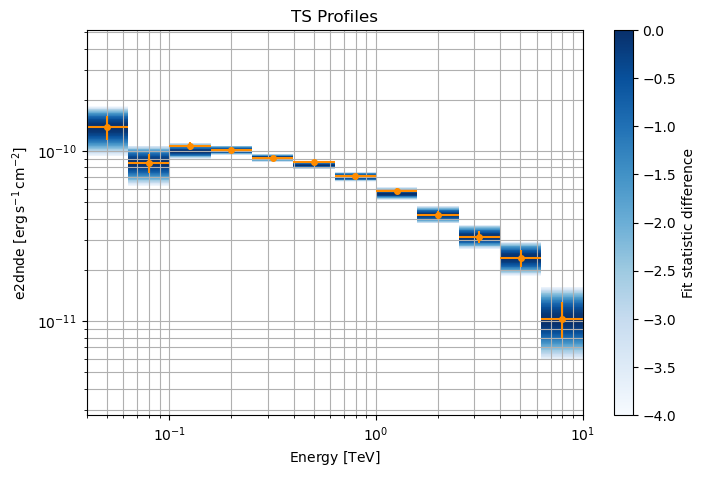

In [105]:
plt.figure(figsize=(8,5))
ax = flux_points.plot(sed_type="e2dnde", **plot_ts_kwargs)

flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
plt.xlim(e_plot_min.value, e_plot_max.value)

plt.grid(which='both')
plt.title('TS Profiles')

<Axes: >

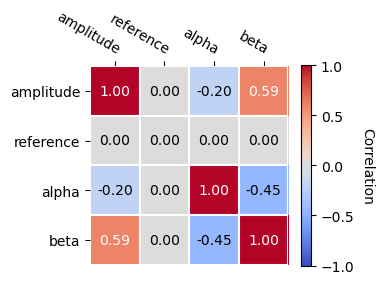

In [106]:
# Fit model covariance matrix plot
model_best.covariance.plot_correlation()

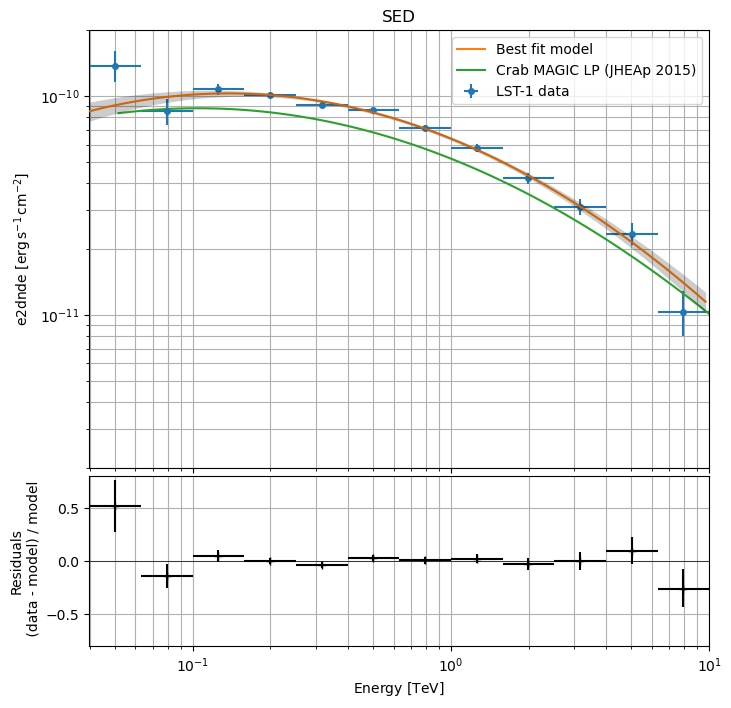

In [107]:
fig_sed = plt.figure(figsize=(8,8))

gs2 = GridSpec(7, 1)

gs2.update(hspace=0.1)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_sed.add_subplot(*args1)
fig_gs2 = fig_sed.add_subplot(*args2)

FluxPointsDataset(data=flux_points, models=model_best).plot_spectrum(
    ax=fig_gs1, 
    kwargs_fp=sed_plot_kwargs, 
)

create_crab_spectral_model("magic_lp").plot(
    ax=fig_gs1, **sed_magic_ref_kwargs, label=ref_label
)

fig_gs1.legend()
fig_gs1.set_xlim(e_plot_min.value, e_plot_max.value)
fig_gs1.set_ylim(2e-12, 2e-10)
fig_gs1.tick_params(labelbottom=False)

fig_gs1.grid(which='both')
fig_gs1.set_title('SED')

flux_points_dataset.plot_residuals(ax=fig_gs2, method='diff/model')
fig_gs2.grid(which='both')
fig_gs2.set_xlim(e_plot_min.value, e_plot_max.value);

Text(0, 0.5, 'Residuals \n (data-model)/sqrt(model)')

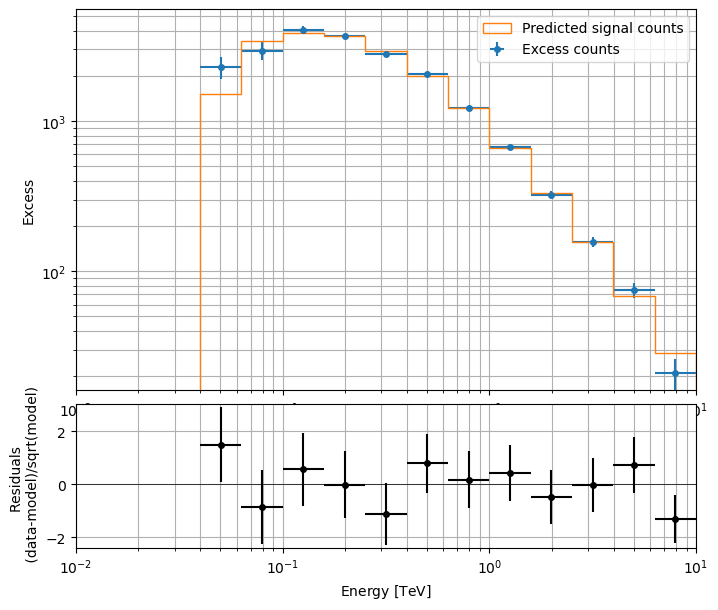

In [108]:
fig = plt.figure(figsize=(8,7))
gs = GridSpec(7, 1)

args1 = [gs[:5,:]]
args2 = [gs[5:,:]]
kwargs_res = {"method": "diff/sqrt(model)"}

fig_gs1 = fig.add_subplot(*args1)
fig_gs2 = fig.add_subplot(*args2)

stacked_dataset.plot_excess(fig_gs1)
fig_gs1.grid(which="both")
fig_gs1.set_ylabel("Excess")

stacked_dataset.plot_residuals_spectral(fig_gs2, **kwargs_res, region=stacked_dataset.counts.geom.region)
fig_gs2.grid(which="both")

fig_gs2.set_ylabel(f"Residuals \n (data-model)/sqrt(model)")

Text(0.5, 1.0, 'Differential spectrum')

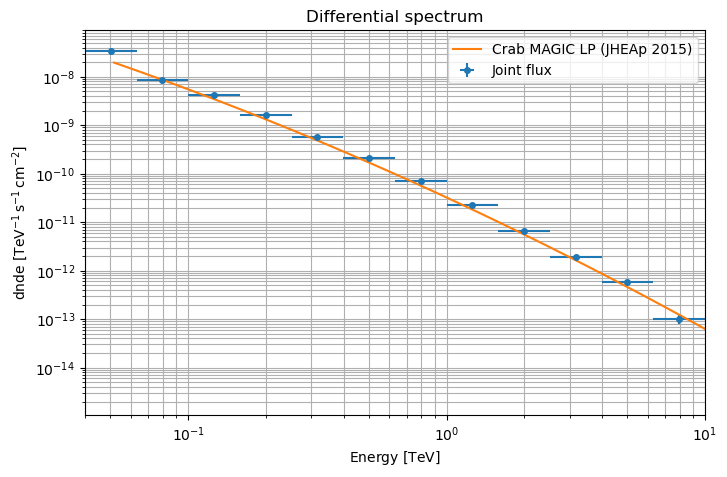

In [109]:
plt.figure(figsize=(8,5))

flux_points.plot(sed_type="dnde", label='Joint flux')
create_crab_spectral_model("magic_lp").plot(**ds_magic_ref_kwargs, label=ref_label)
plt.xlim(e_plot_min.value, e_plot_max.value)
plt.grid(which='both')
plt.legend()
plt.title('Differential spectrum')

# 14. Save the SED and LC Flux Points and Model to separate files
## This way, one can plot different SEDs and LCs together

In [110]:
# Dump the model and Optimization results into a file
# f = open(dl3_path / f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_model_dict.dat', 'wb')
f = open(f'output/post_DL3_analysis/{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_model_dict.dat', 'wb')
pickle.dump(model_final, f)
f.close()

In [111]:
# Create a temporary fits file with the SED and LC Flux Points tables
f = fits.HDUList(
    [
        fits.PrimaryHDU(),
        fits.BinTableHDU(flux_points.to_table(), name="SED"),
        fits.BinTableHDU(lc_1d.to_table(sed_type="flux", format="lightcurve"), name="LC"),
    ]
)
f.writeto(
    # dl3_path / f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    f'output/post_DL3_analysis/{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    overwrite=True
)

### Example on reading back and plotting the LC and SED

In [112]:
flux_model = open(
    # dl3_path / f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_model_dict.dat', 
    f'output/post_DL3_analysis/{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_model_dict.dat',
    'rb'
)
model_dict = pickle.load(flux_model)
flux_model.close()

In [113]:
flux_points = FluxPoints.read(
    # dl3_path / f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    f'output/post_DL3_analysis/{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    hdu="SED",
    format="gadf-sed",
    reference_model=SkyModel.from_dict(model_dict)
)
flux_points_lc = FluxPoints.read(
    # dl3_path / f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    f'output/post_DL3_analysis/{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    hdu="LC",
    sed_type="flux", 
    format="lightcurve",
    reference_model=SkyModel.from_dict(model_dict)
)


Text(0.5, 1.0, 'SED')

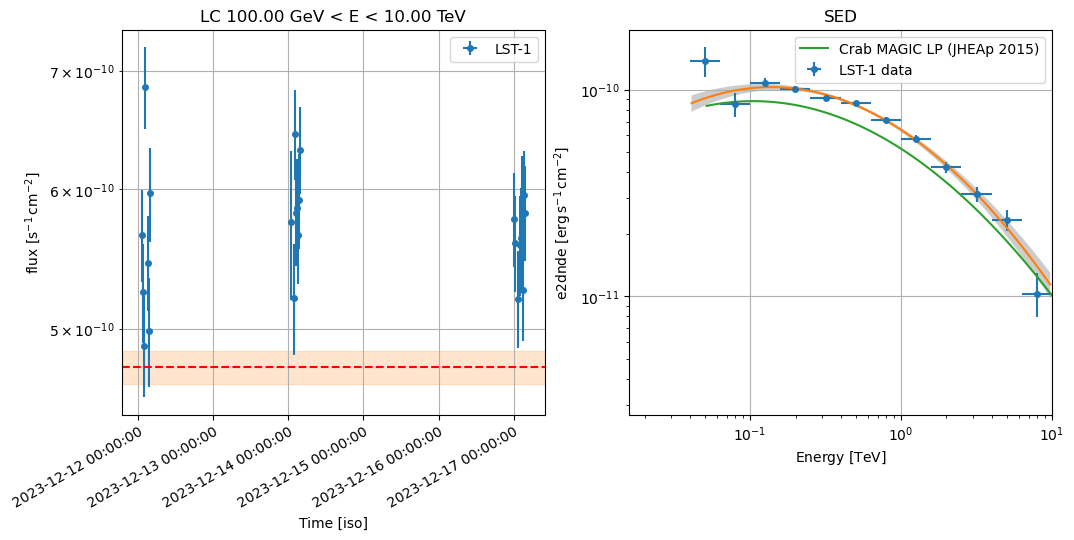

In [114]:
plt.figure(figsize=(12,5))

plt.subplot(121)
flux_points_lc.plot(sed_type="flux", **lc_kwargs)
plt.grid(which="both")
plt.title(
    f'LC {flux_points_lc.to_table(sed_type="flux", format="lightcurve")["e_min"].quantity[0][0].to(u.GeV):.2f} < ' +
    f'E < {flux_points_lc.to_table(sed_type="flux", format="lightcurve")["e_max"].quantity[0][0]:.2f}'
)
plt.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', label=ref_label
)
plt.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)


plt.subplot(122)
flux_points.plot(sed_type="e2dnde", **sed_plot_kwargs)
flux_points.reference_model.spectral_model.plot(**sed_kwargs)
flux_points.reference_model.spectral_model.plot_error(**sed_kwargs)
create_crab_spectral_model("magic_lp").plot(
    **sed_magic_ref_kwargs, label=ref_label
)
plt.legend()
plt.grid()
plt.title("SED")